# Investigation of performance of net mechanism on a two dimensional toy data set

In [1]:
import second_moment_experiments_main as experiment
import pickle
import matplotlib
import matplotlib.pyplot as plt
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
from exputils import extract_data, initialise_netmech_containers, initialise_adassp_reg_containers, initialise_netmech_reg_containers 
from baselines import Regression, DPRegression
import numpy as np
# %matplotlib tk

In [2]:
# Load data 
exp_name = 'exp_feature_lattice_denisty_target_3'
with open ('D:/Thesis/Experiments/exp_feature_lattice_density_target_3/' + exp_name, "rb") as container:
    results = pickle.load(container)

## Feature lattice discretisation

$\textbf{Setup}$: Initially, set the targets and features lattice densities to $num\_points\_targets = 3$ and $num\_points\_features = 3$. Then increment the density of the feature in steps of $1$ up to $20$. Repeat the experiment for $\varepsilon \in \{0.1:1\} \cup \{1:10\}$. Compare the RMSE of the regression perfromed on the net mechansim synthetic output with the RMSE of the ADASSP algorithm and look at the sample utilities...

### Parameter setup

In [3]:
# Default parameters list
dimensionality = 2
num_records = 40
test_frac = 0.5
batch_size = 1000
directory = 'D:/Thesis/Experiments/exp_feature_lattice_density_target_3/'
parallel = False
save_data = True
partition_method = 'fast_2'
workers = -1
num_samples = 25
sample_parallel = False 
load_data = True
seed = 23
num_points_targets = 3

In [4]:
num_points_max = 20
num_points_min = 3
num_points_features_vec = range(num_points_min, num_points_max + 1)
epsilon_vec = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

### Run the experiments

In [ ]:
# Collect results
results = {key: [] for key in epsilon_vec}
for epsilon in epsilon_vec:
    for num_points_features in num_points_features_vec:
        results[epsilon].append(experiment.second_order_moment_experiment(dimensionality = dimensionality, num_records = num_records, test_frac = test_frac, batch_size = batch_size,directory = directory, parallel = parallel, save_data = save_data,\
                                                                 partition_method = partition_method, workers = workers, num_samples = num_samples,\
                                                                 sample_parallel = sample_parallel, load_data = load_data, num_points_targets = num_points_targets,\
                                                                 num_points_features = num_points_features, epsilon = epsilon, seed = seed))

In [ ]:
# Save the results for latter access
exp_name = 'exp_feature_lattice_denisty_target_3'
with open (directory + exp_name, "wb") as container:
    pickle.dump(results, container)

## Analyse the data

In [5]:
# Experimental data containers
delta_cov_norms_f, delta_corr_norms_2, avg_2_norms, double_std_2_norms, avg_f_norms, double_std_f_norms, max_utilities, sample_utilities, max_sampled_utilities, min_sampled_utilities,\
avg_samples_utility, double_std_utility, avg_samples_score, double_std_score, synthetic_datasets_vec, delta_opt_avg, \
delta_opt_best, delta_opt_worst, test_set, private_data = initialise_netmech_containers(epsilon_vec)

In [6]:
# Extract data from the results data structure 
for key in results:
    delta_cov_norms_f[key], delta_corr_norms_2[key], avg_2_norms[key], double_std_2_norms[key], avg_f_norms[key], double_std_f_norms[key], max_utilities[key], sample_utilities[key],\
    max_sampled_utilities[key], min_sampled_utilities[key], avg_samples_utility[key], double_std_utility[key], avg_samples_score[key],\
    double_std_score[key], synthetic_datasets_vec[key], delta_opt_avg[key], delta_opt_best[key], delta_opt_worst[key], test_set[key], \
    private_data[key] = extract_data(results[key]) 

In [7]:
# Initialise containers for the regression on the synthetic data sets released with netmechanism
net_mech_reg_coefs, predictive_errs_netmech, min_predictive_errs_netmech, mean_predictive_errs_netmech,\
double_std_predictive_errs_netmech, singular_indices = initialise_netmech_reg_containers(epsilon_vec)

# Initialise containers for the regression on the synthetic data sets with parameters released by ADASSP
adassp_reg_coef, predictive_err_adassp, min_predictive_err_adassp, mean_predictive_err_adassp, double_std_predictive_err_adassp = initialise_adassp_reg_containers(epsilon_vec)

In [8]:
# Fit ADASSP to the private dataset and calculate the predictive error
for epsilon in epsilon_vec:
    adassp_regressor = DPRegression()
    adassp_reg_coef[epsilon] = adassp_regressor.get_parameters(private_data[epsilon].features, private_data[epsilon].targets,\
                                                           num_samples, epsilon, seed = 15)
    predictive_err_adassp[epsilon] = Regression().calculate_predictive_error(private_data[epsilon].test_data, adassp_reg_coef[epsilon])
    min_predictive_err_adassp[epsilon] = np.min(predictive_err_adassp[epsilon])
    mean_predictive_err_adassp[epsilon] = np.mean(predictive_err_adassp[epsilon])
    double_std_predictive_err_adassp[epsilon] = 2*np.std(predictive_err_adassp[epsilon])
    # print ("Min predictive error adassp for eps " + str(epsilon) , min_predictive_err_adassp[epsilon])
    # print ("Mean predictive error adassp " + str(epsilon), mean_predictive_err_adassp[epsilon])
    # print ("Twice the std of predictive err adassp " + str(epsilon), double_std_predictive_err_adassp[epsilon])

In [9]:
# Perform regression on the datasets released with the net mechanism and calculate predictive error statistics
for epsilon in epsilon_vec:
    for synthetic_datasets in synthetic_datasets_vec[epsilon]:
        netmech_regressor = Regression()
        net_mech_reg_coef = netmech_regressor.fit_data(synthetic_datasets)
        net_mech_reg_coefs[epsilon].append(net_mech_reg_coef)
        predictive_err_netmech = netmech_regressor.calculate_predictive_error(private_data[epsilon].test_data, net_mech_reg_coef)
        singular_indices[epsilon].append(netmech_regressor.singular_indices)
        predictive_errs_netmech[epsilon].append(predictive_err_netmech)
        min_predictive_errs_netmech[epsilon].append(np.min(predictive_err_netmech))
        mean_predictive_errs_netmech[epsilon].append(np.mean(predictive_err_netmech))
        double_std_predictive_errs_netmech[epsilon].append(2*np.std(predictive_err_netmech))
    print("Overall minimum predictive error for netmechanism with epsilon " + str(epsilon) + " is {}, obtained for n_t = {}."\
          .format(str(np.min(np.array(min_predictive_errs_netmech[epsilon]))),\
                  str(list(num_points_features_vec)[np.argmin(np.array(min_predictive_errs_netmech[epsilon]))])))
    print("Minimum average predictive error for netmechanism with epsilon " + str(epsilon) + " is {}, obtained for n_t = {}."\
          .format(str(np.min(np.array(mean_predictive_errs_netmech[epsilon]))),\
                  str(list(num_points_features_vec)[np.argmin(np.array(mean_predictive_errs_netmech[epsilon]))])))

Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Overall minimum predictive error for netmechanism with epsilon 0.1 is 0.03562937639947024, obtained for n_t = 3.
Minimum average predictive error for netmechanism with epsilon 0.1 is 0.3092318174248802, obtained for n_t = 3.
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning

C:\Users\alexc\OneDrive\Documents\GitHub\Thesis\baselines.py:121: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  parameters[index] = np.linalg.lstsq(Sigma_tensor[index,:,:], correlations[index])[0]



Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Overall minimum predictive error for netmechanism with epsilon 5.0 is 0.032703823241160404, obtained for n_t = 17.
Minimum average predictive error for netmechanism with epsilon 5.0 is 0.15294592023700418, obtained for n_t = 3.
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
War

## Plot the results

In [10]:
xcoordinate = list(num_points_features_vec)
#yticks_low_vec = [-0.8, -0.8, -0.8,-0.8,-0.8,-0.8,-0.8,-0.8,-0.8, -0.65, -0.35, -0.2]
yticks_low = -1

#### Average samples utility

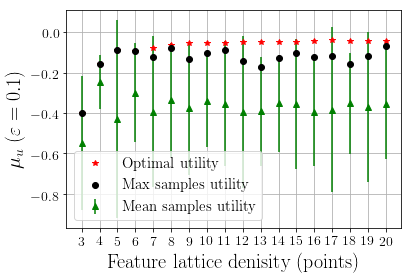

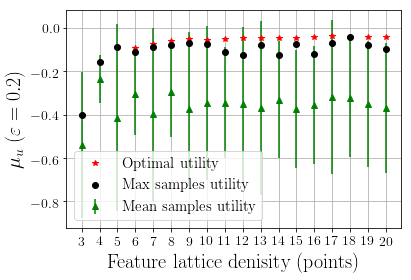

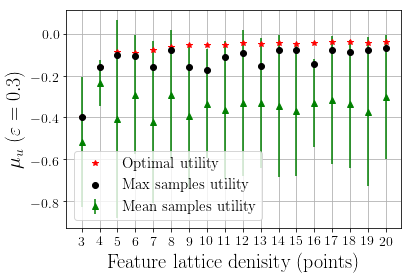

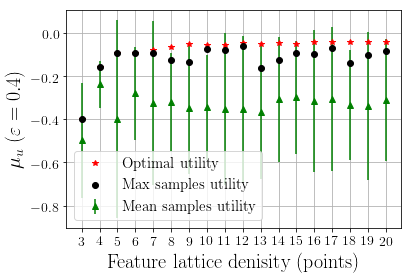

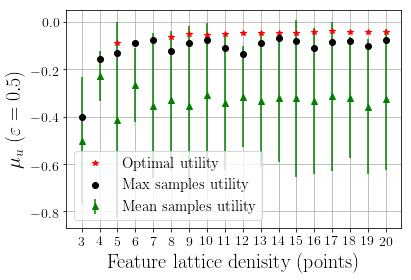

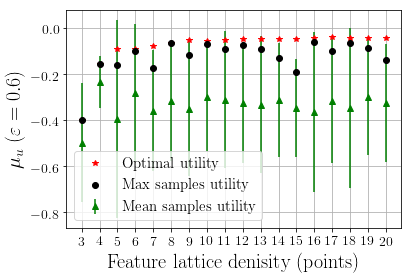

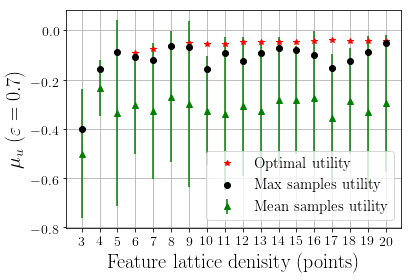

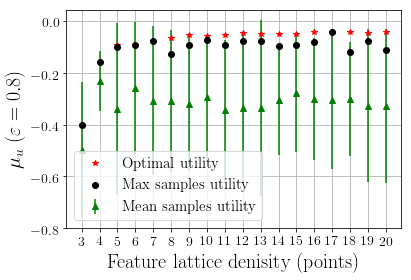

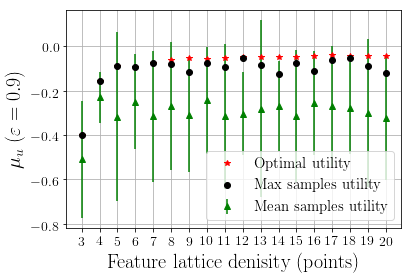

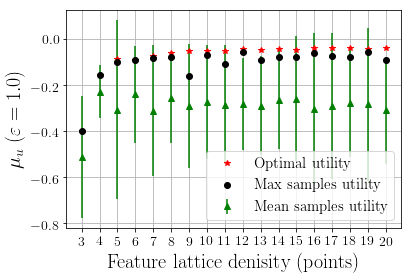

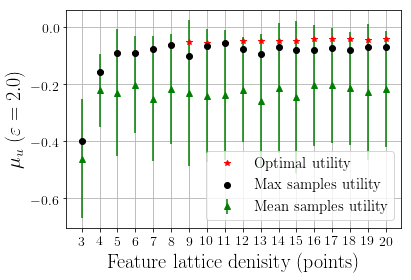

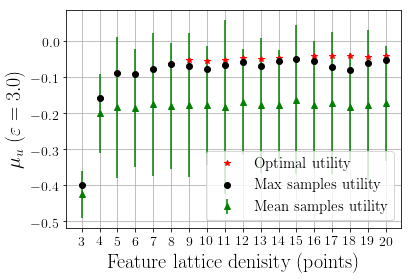

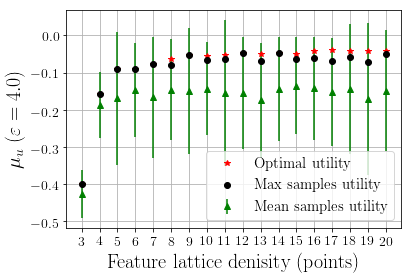

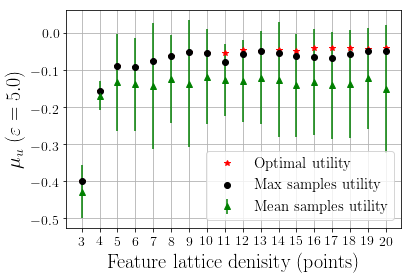

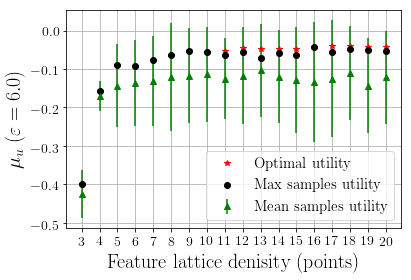

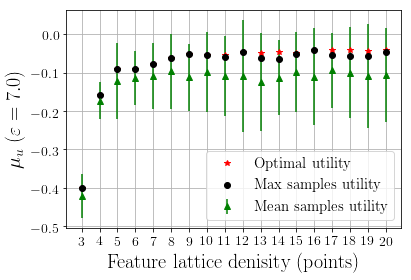

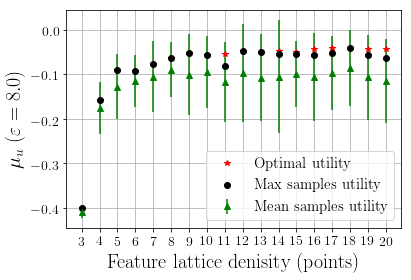

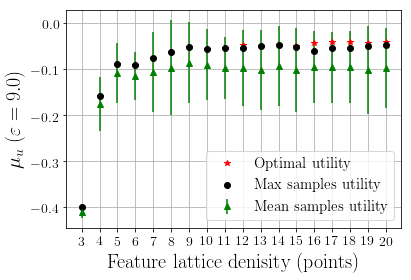

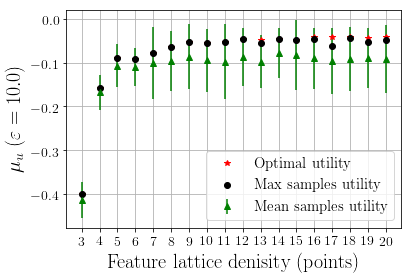

In [11]:
def plot_avg_utility_graphs(yticks_low, xcoordinate, avg_samples_utility, double_std_utility, max_utilities, max_sampled_utilities,\
                            epsilon):
    plt.errorbar(xcoordinate, avg_samples_utility, yerr = double_std_utility, fmt = 'g^', label = 'Mean samples utility')
    plt.plot(xcoordinate, max_utilities, 'r*', label = 'Optimal utility')
    plt.plot(xcoordinate, max_sampled_utilities, 'ko', label = 'Max samples utility')
    plt.xticks(xcoordinate)
    # plt.yticks(np.arange(yticks_low, 0.02, step = 0.05))
    plt.xlabel('Feature lattice denisity (points)', fontsize = 20)
    plt.ylabel(r'$\mu_u$ ($\varepsilon =' + str(epsilon) + '$)', fontsize = 20)
    plt.legend(fontsize = 15)
    plt.grid(True)
    plt.show()

for epsilon in epsilon_vec:
    plot_avg_utility_graphs(yticks_low, xcoordinate, avg_samples_utility[epsilon], double_std_utility[epsilon],\
                            max_utilities[epsilon], max_sampled_utilities[epsilon], epsilon)
    

## Sanity check: used different sampling method and batch sizes

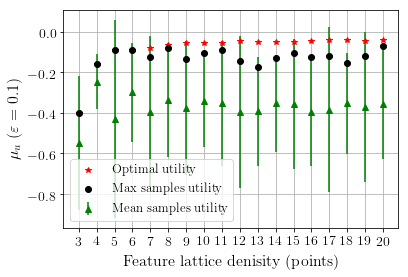

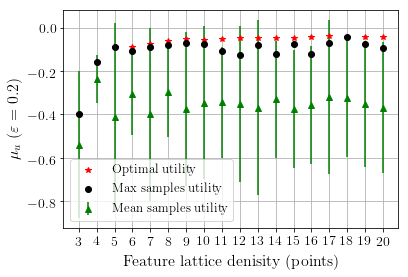

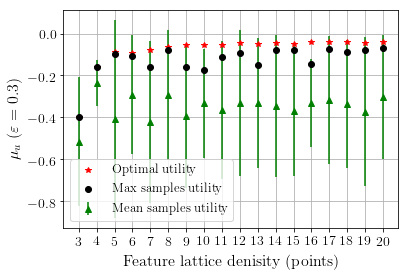

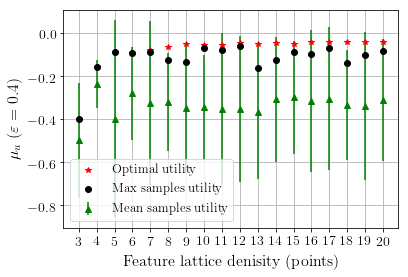

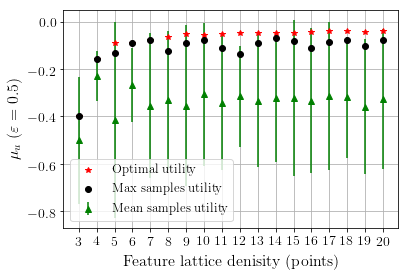

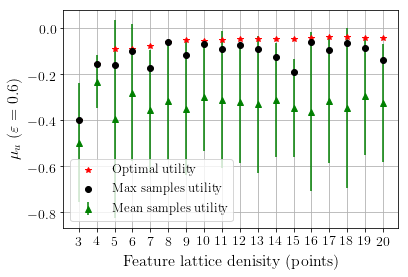

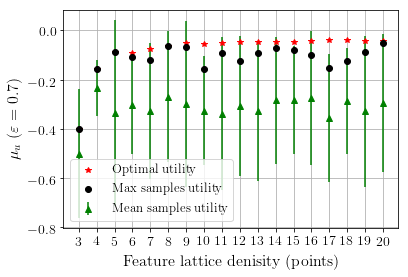

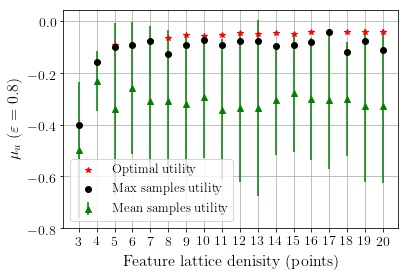

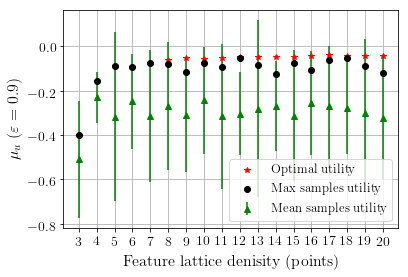

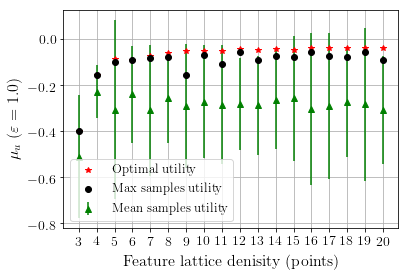

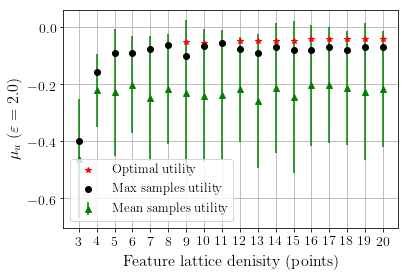

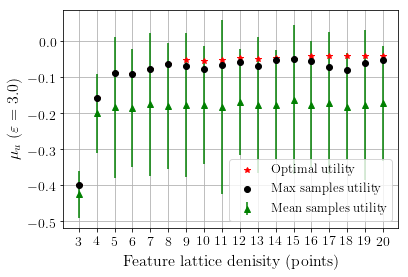

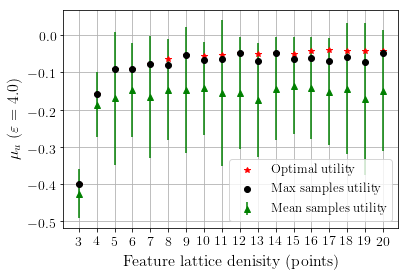

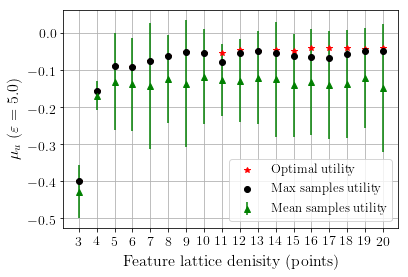

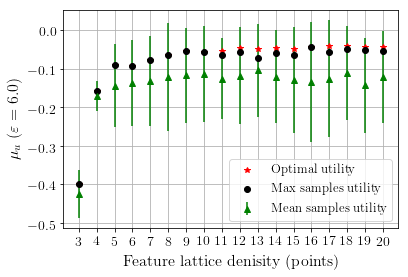

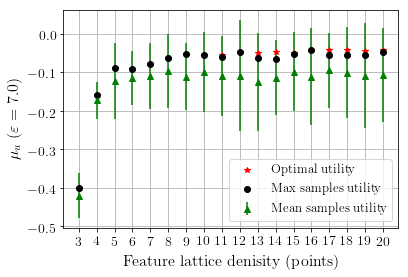

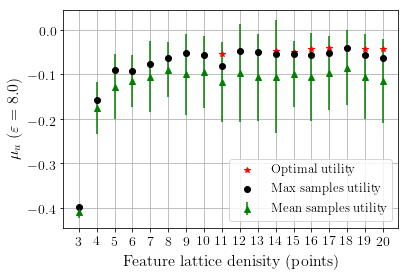

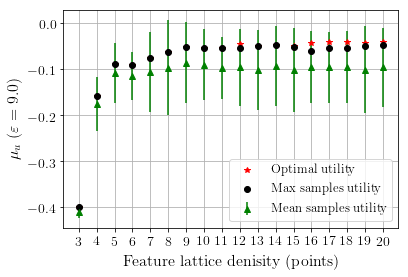

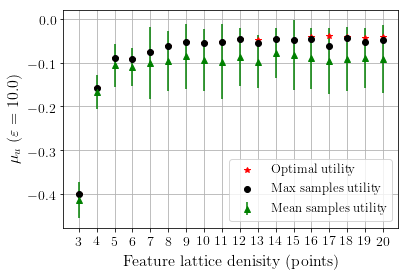

In [12]:
def plot_avg_utility_graphs(yticks_low, xcoordinate, avg_samples_utility, double_std_utility, max_utilities, max_sampled_utilities,\
                            epsilon):
    plt.errorbar(xcoordinate, avg_samples_utility, yerr = double_std_utility, fmt = 'g^', label = 'Mean samples utility')
    plt.plot(xcoordinate, max_utilities, 'r*', label = 'Optimal utility')
    plt.plot(xcoordinate, max_sampled_utilities, 'ko', label = 'Max samples utility')
    plt.xticks(xcoordinate)
    # plt.yticks(np.arange(yticks_low, 0.02, step = 0.05))
    plt.xlabel('Feature lattice denisity (points)', fontsize = 16)
    plt.ylabel(r'$\mu_u$ ($\varepsilon =' + str(epsilon) + '$)', fontsize = 16)
    plt.legend(fontsize = 13)
    plt.grid(True)
    plt.show()

for epsilon in epsilon_vec:
    plot_avg_utility_graphs(yticks_low, xcoordinate, avg_samples_utility[epsilon], double_std_utility[epsilon],\
                            max_utilities[epsilon], max_sampled_utilities[epsilon], epsilon)
    

#### Plot samples distribution

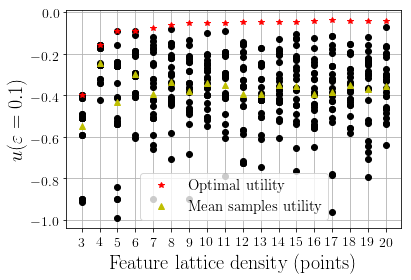

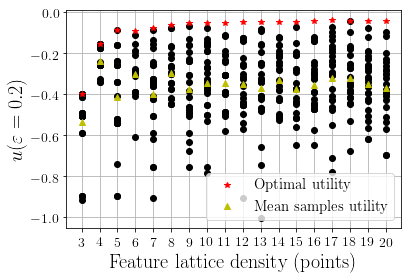

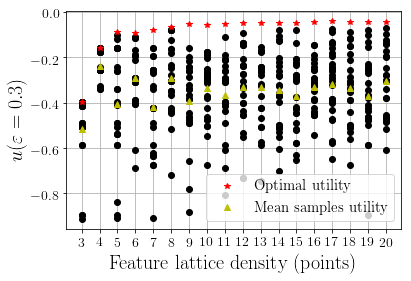

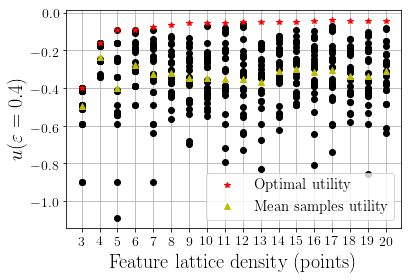

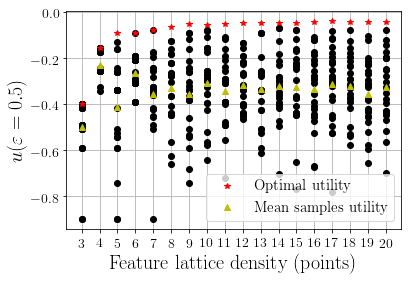

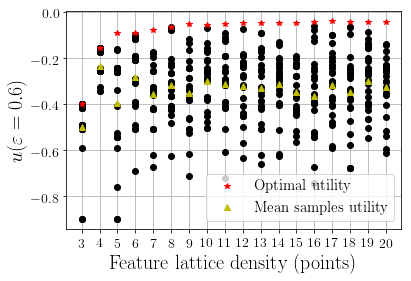

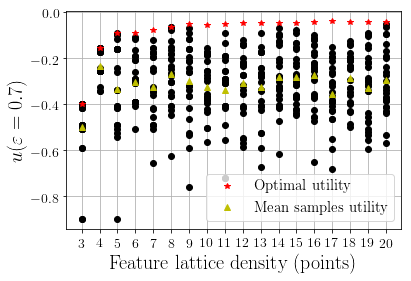

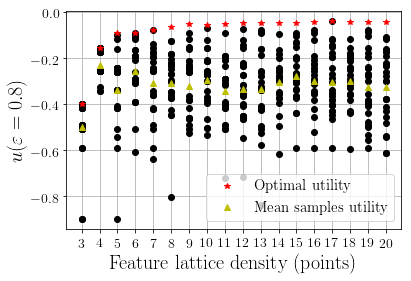

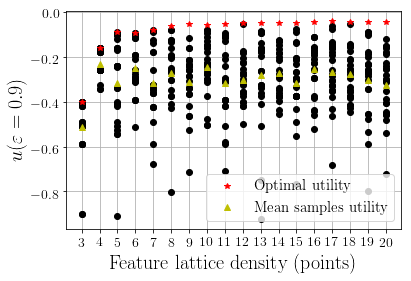

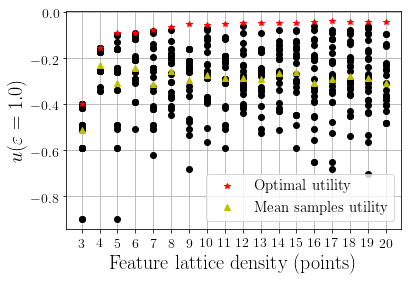

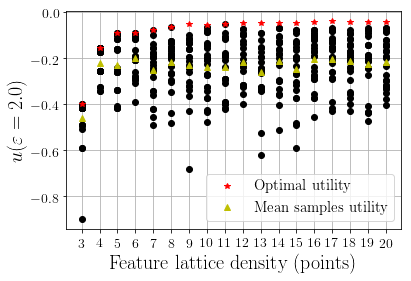

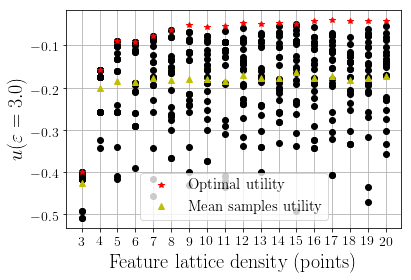

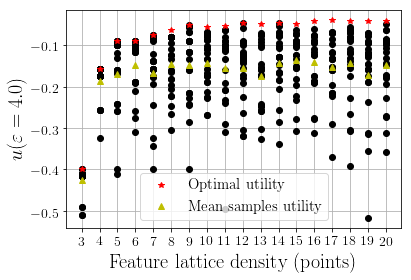

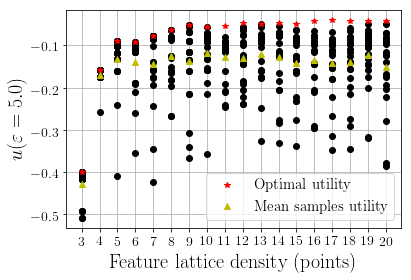

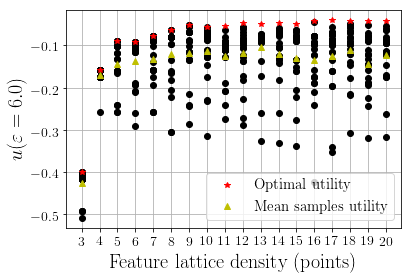

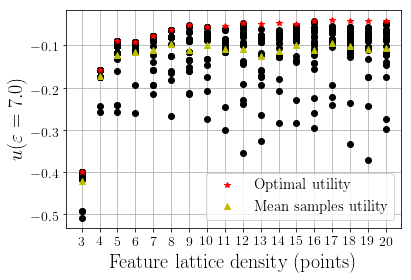

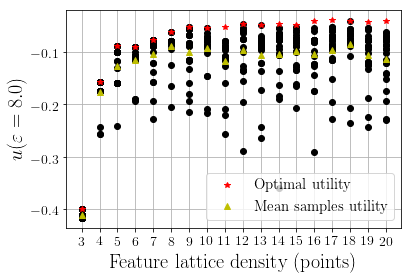

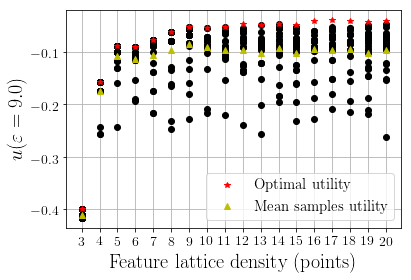

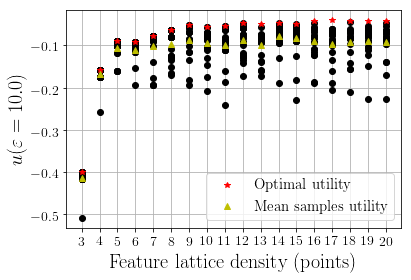

In [13]:
def plot_samples_distrib(xcoordinate, sample_utilities, max_utilities, avg_samples_utility, epsilon):
    for sample_batch, coordinate in zip(sample_utilities, xcoordinate):
        plt.plot([coordinate]*len(sample_batch), sample_batch, 'ko')
    plt.ylabel(r'$u (\varepsilon = ' + str(epsilon) + '$)', fontsize = 20)
    plt.xlabel('Feature lattice density (points)', fontsize = 20)
    plt.plot(xcoordinate, max_utilities, 'r*', label = 'Optimal utility')
    plt.plot(xcoordinate, avg_samples_utility, 'y^', label = 'Mean samples utility')
    plt.xticks(xcoordinate)
    plt.legend(fontsize = 15)
    plt.grid(True)
    plt.show()
    
for epsilon in epsilon_vec:
    plot_samples_distrib(xcoordinate, sample_utilities[epsilon], max_utilities[epsilon], avg_samples_utility[epsilon], epsilon)
    

#### Difference between optimal utility and and average sampled utility

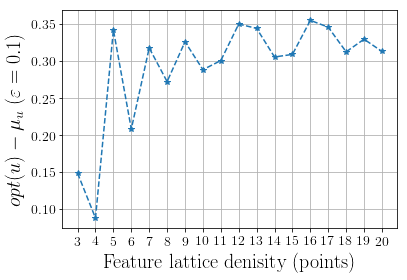

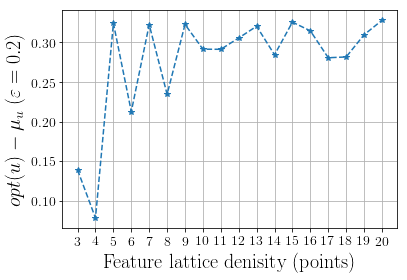

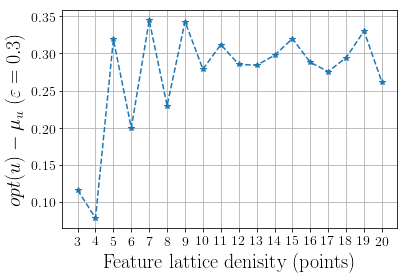

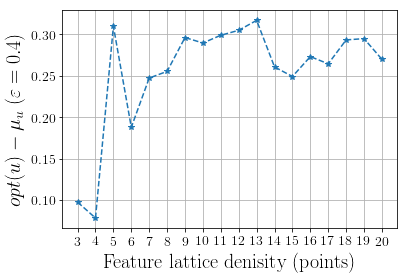

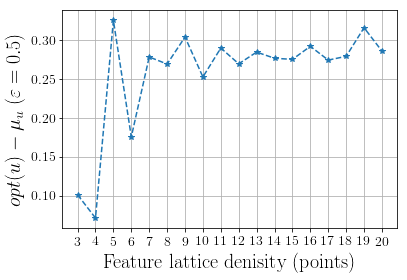

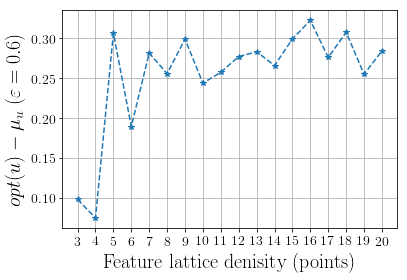

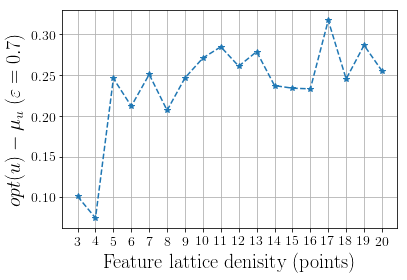

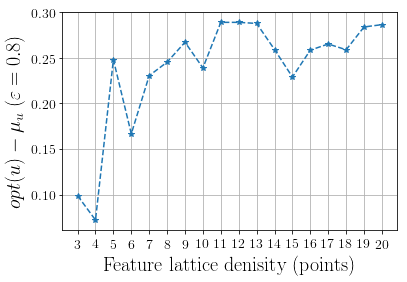

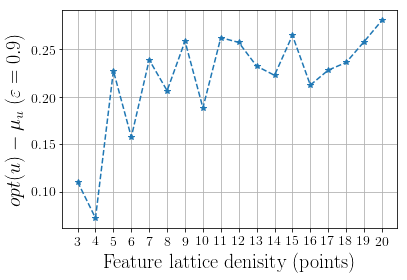

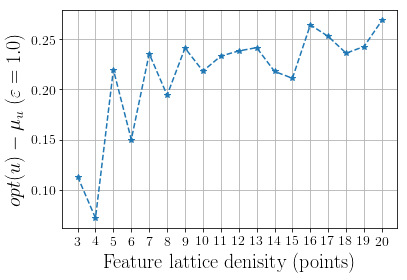

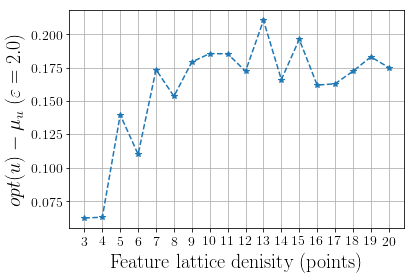

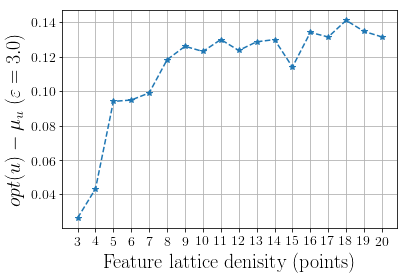

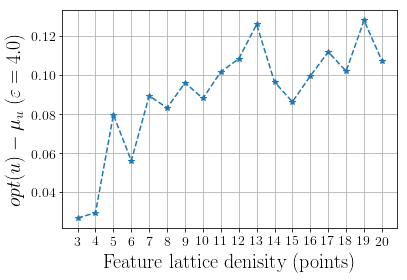

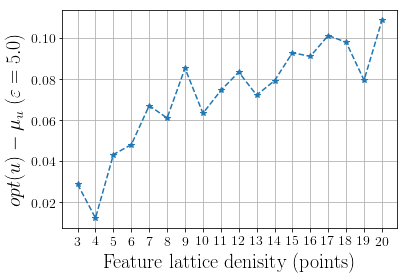

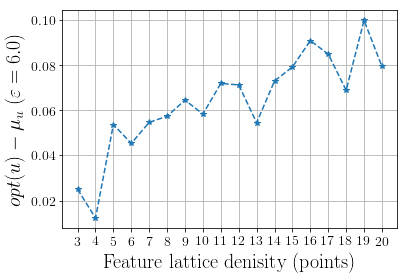

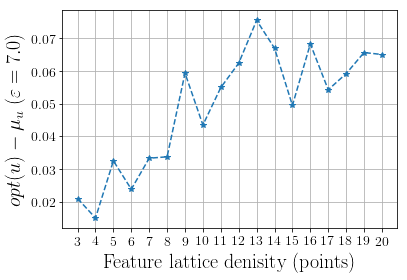

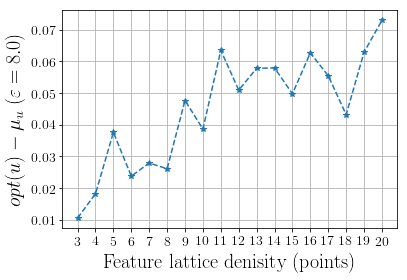

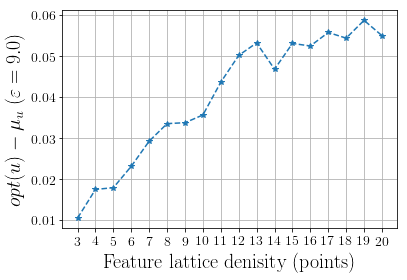

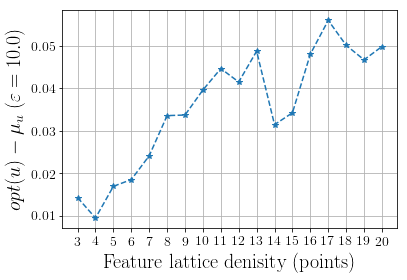

In [14]:
def delta_opt_avg_util(xcoordinate, delta_opt_avg, epsilon):
    plt.plot(xcoordinate, delta_opt_avg, '--*')
    plt.xticks(xcoordinate)
    # plt.yticks(np.arange(yticks_low, 0.02, step = 0.05))
    plt.xlabel('Feature lattice denisity (points)', fontsize = 20)
    plt.ylabel(r'$opt(u) - \mu_u$ ($\varepsilon =' + str(epsilon) + '$)', fontsize = 20)
    plt.grid(True)
    plt.show()
    
for epsilon in epsilon_vec:
    delta_opt_avg_util(xcoordinate, delta_opt_avg[epsilon], epsilon)


#### Difference between optimal utility and max sampled utility

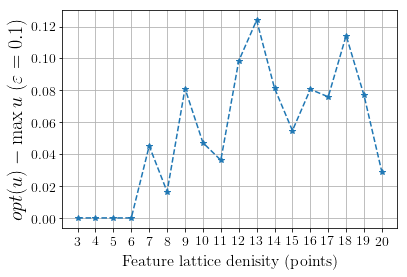

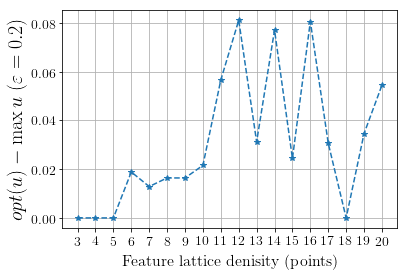

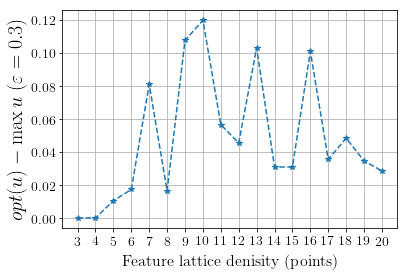

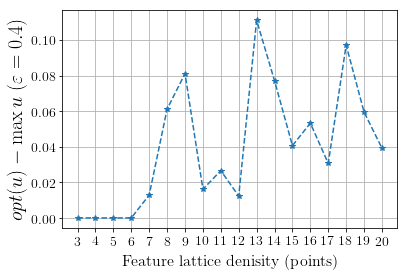

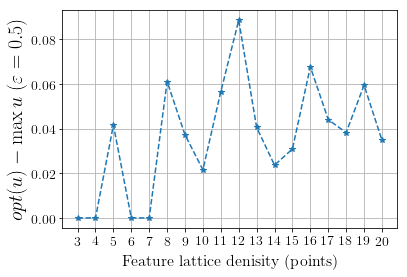

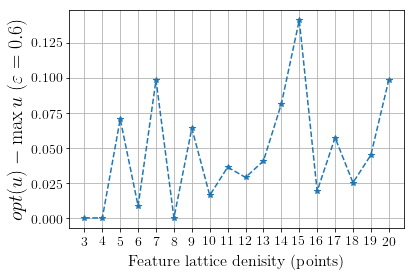

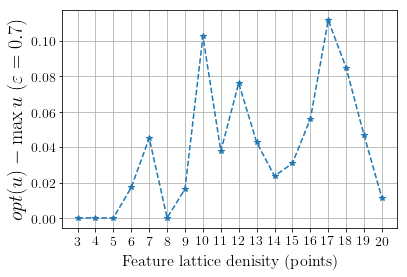

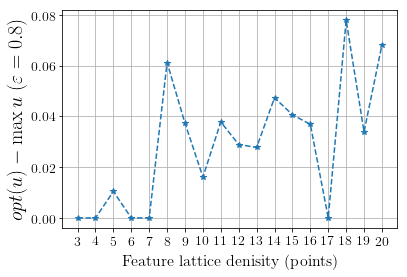

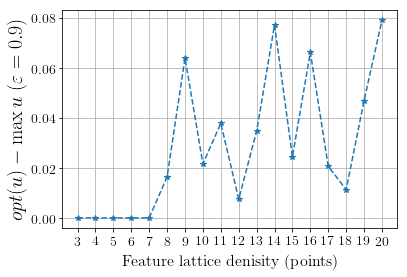

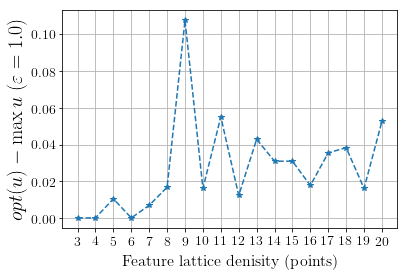

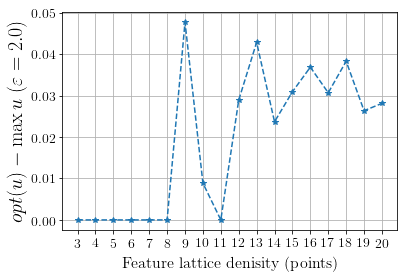

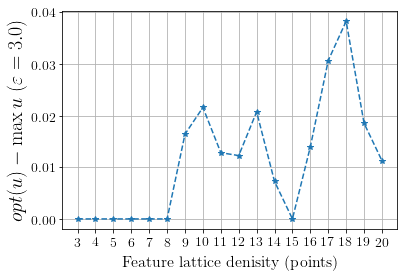

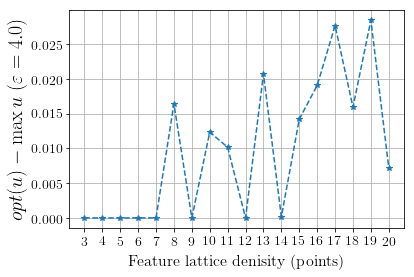

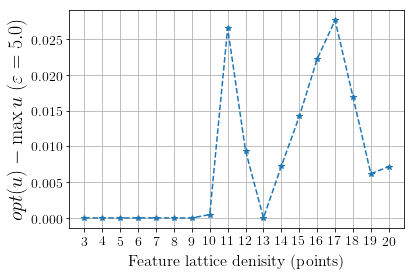

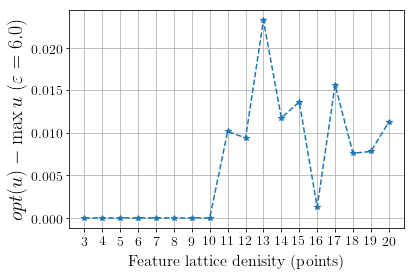

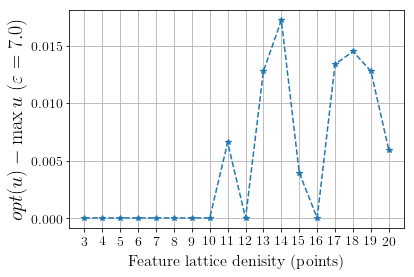

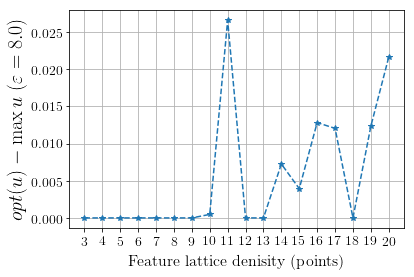

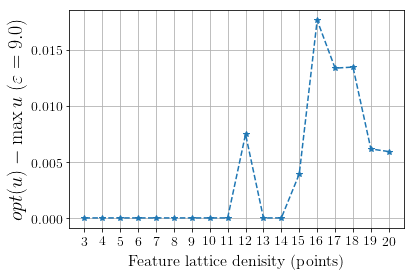

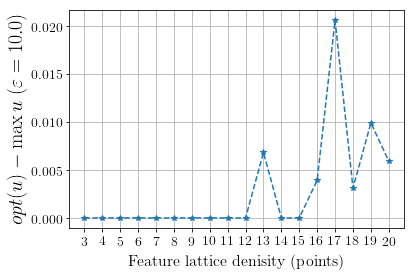

In [15]:
def delta_opt_best_util(xcoordinate, delta_opt_best, epsilon):
    plt.plot(xcoordinate, delta_opt_best, '--*')
    plt.xticks(xcoordinate)
    # plt.yticks(np.arange(yticks_low, 0.02, step = 0.05))
    plt.xlabel('Feature lattice denisity (points)', fontsize = 16)
    plt.ylabel(r'$opt(u) - \max u$ ($\varepsilon =' + str(epsilon) + '$)', fontsize = 20)
    plt.grid(True)
    plt.show()
    
for epsilon in epsilon_vec:
    delta_opt_best_util(xcoordinate, delta_opt_best[epsilon], epsilon)

#### Difference between optimal utility and worst sampled utility

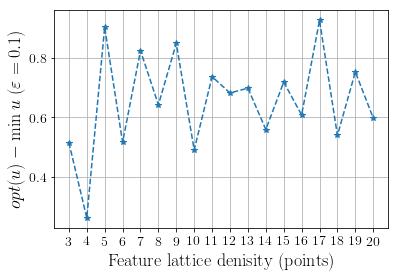

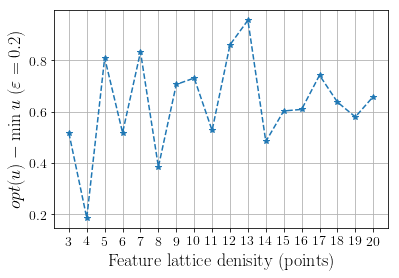

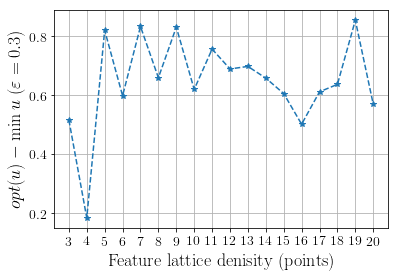

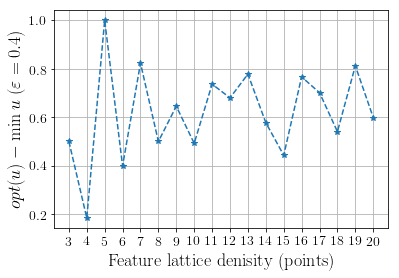

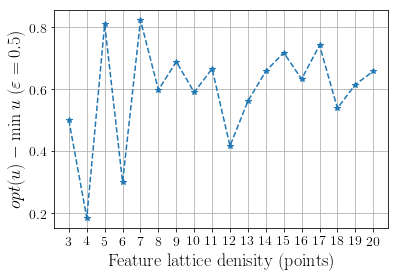

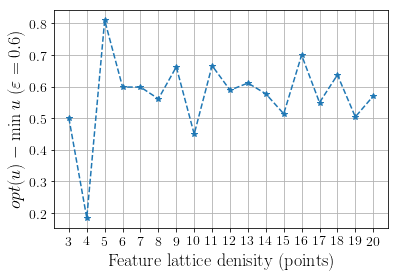

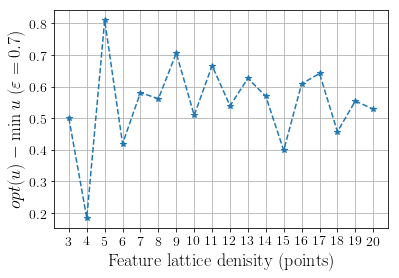

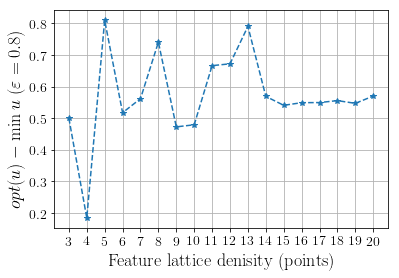

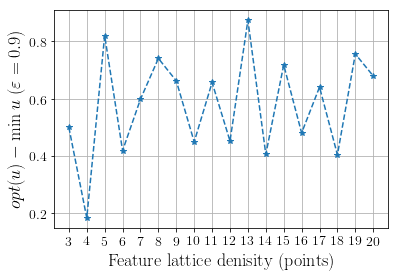

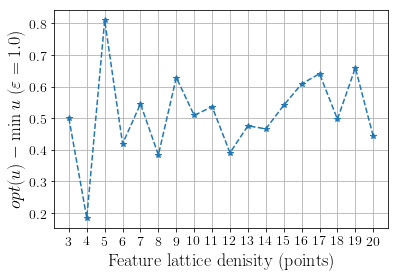

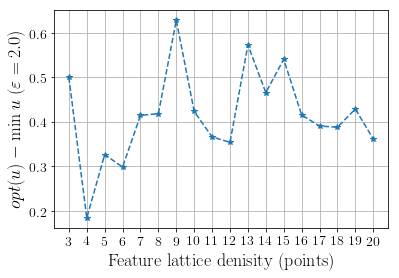

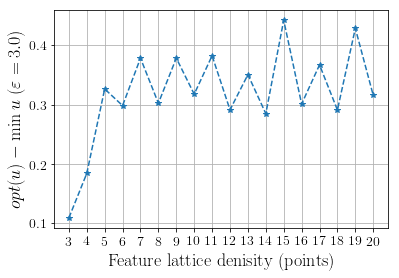

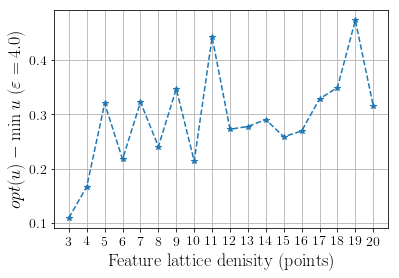

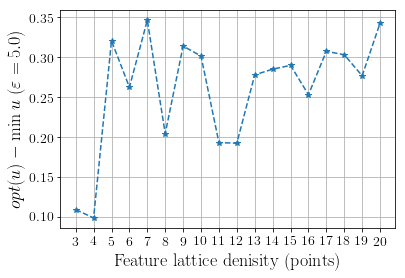

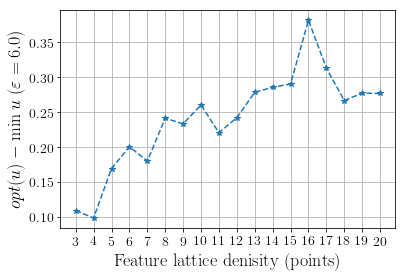

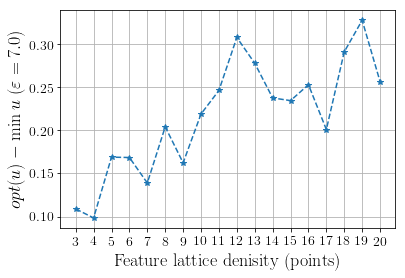

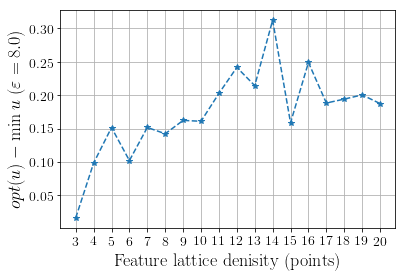

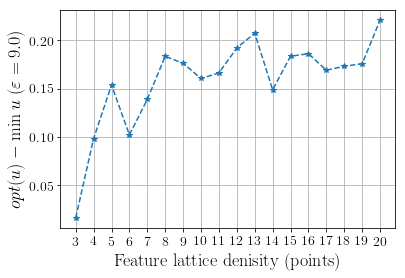

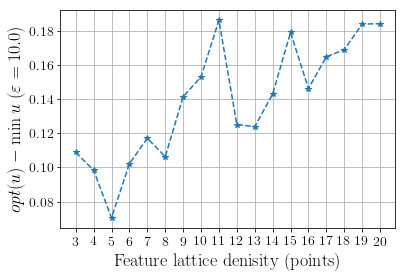

In [16]:
def delta_opt_worst_util(xcoordinate, delta_opt_worst, epsilon):
    plt.plot(xcoordinate, delta_opt_worst, '--*')
    plt.xticks(xcoordinate)
    # plt.yticks(np.arange(yticks_low, 0.02, step = 0.05))
    plt.xlabel('Feature lattice denisity (points)', fontsize = 18)
    plt.ylabel(r'$opt(u) - \min u$ ($\varepsilon =' + str(epsilon) + '$)', fontsize = 18)
    plt.grid(True)
    plt.show()
    
for epsilon in epsilon_vec:
    delta_opt_worst_util(xcoordinate, delta_opt_worst[epsilon], epsilon)

#### RMSE plots

The variance/mean of ADASSP blows up when $\varepsilon$ is around $1$. For example, when setting $\varepsilon = 0.8$, the standard deviation of the ADASSP solution is $23.60$ while the mean is $5.07$ while the minimum RMSE error is $0.03$. This is caused by one sample, for which the RMSE is $120.707$. For that example, the regression coefficients are $-392.68$ and $330.50$. The same sample causes the large standard deviation for the $\varepsilon = 1$ case (plotted). 

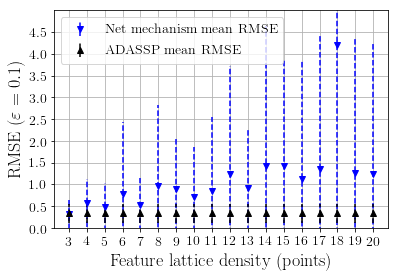

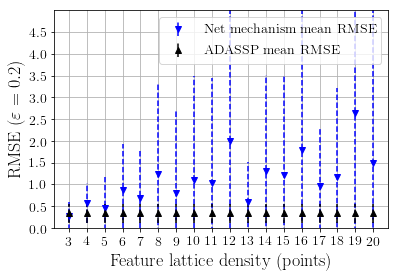

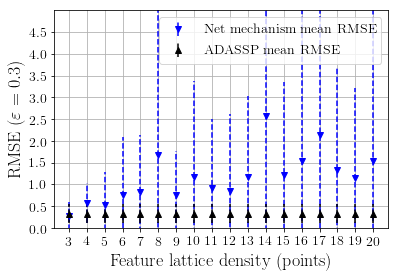

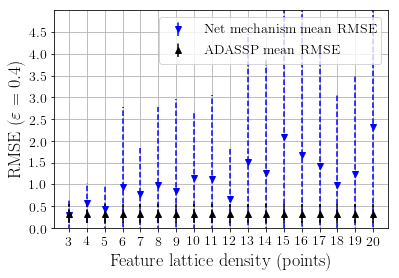

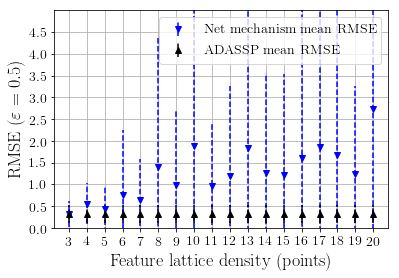

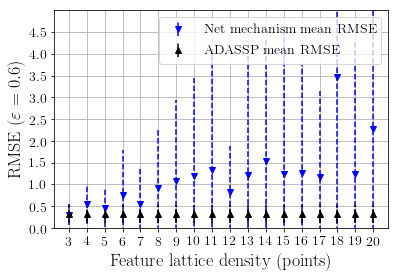

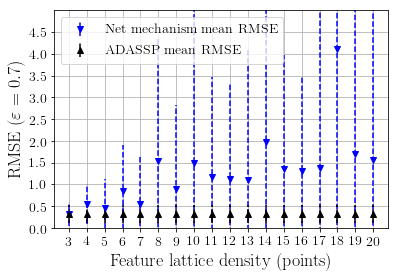

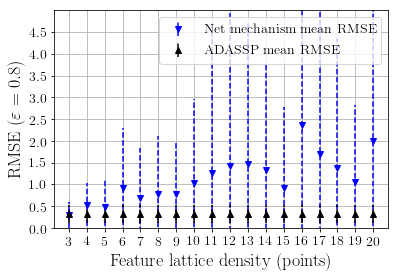

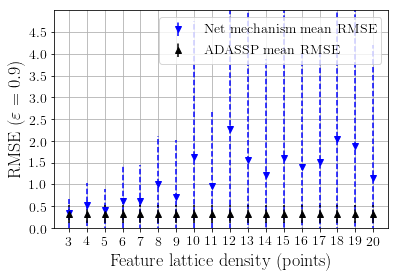

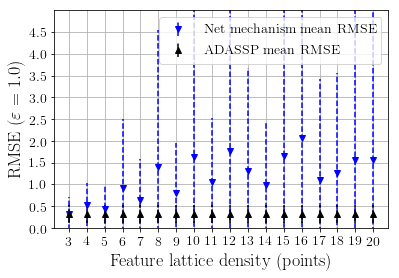

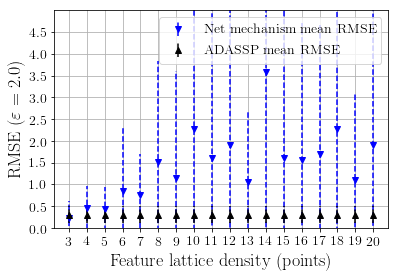

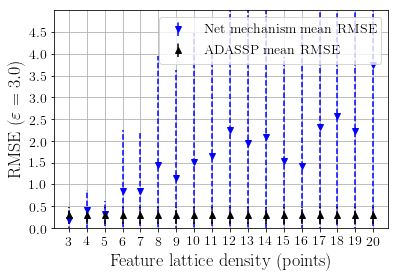

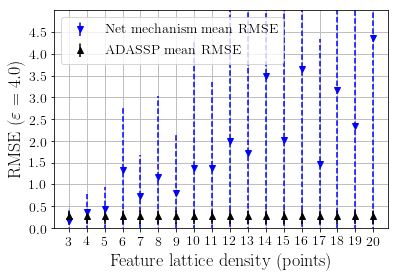

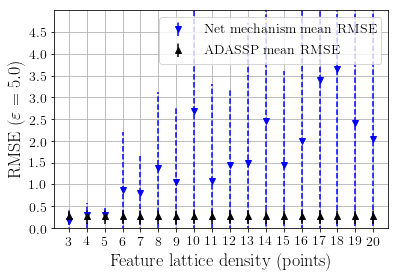

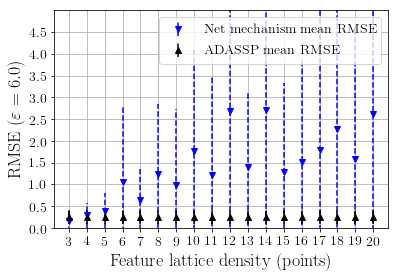

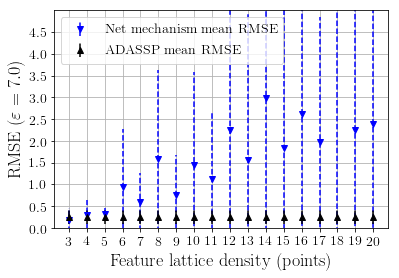

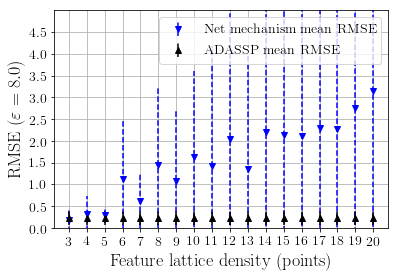

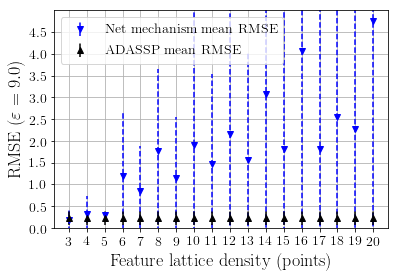

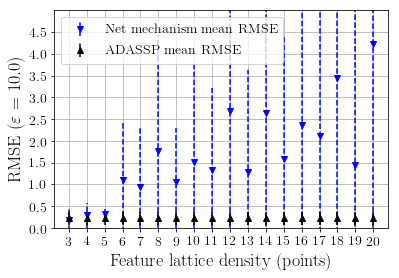

In [17]:
def plot_rmses(xcoordinate, mean_predictive_errs_netmech, double_std_predictive_errs_netmech, mean_predictive_err_adassp, \
               double_std_predictive_err_adassp, epsilon):
    eb = plt.errorbar(xcoordinate, mean_predictive_errs_netmech, yerr = double_std_predictive_errs_netmech, fmt = 'bv', label = 'Net mechanism mean RMSE')
    eb[-1][0].set_linestyle('--')
    plt.xticks(xcoordinate)
    # plt.axhline(y = mean_predictive_err_adassp, color = 'r', linestyle='--', label = 'ADASSP mean RMSE')
    eb1 = plt.errorbar(xcoordinate, [mean_predictive_err_adassp]*len(xcoordinate), yerr = [double_std_predictive_err_adassp]*len(xcoordinate), fmt = 'k^', label = 'ADASSP mean RMSE')
    eb1[-1][0].set_linestyle('--')
    plt.yticks(np.arange(0, 5, step = 0.5))
    plt.ylim([0, 5])
    plt.xlabel('Feature lattice density (points)', fontsize = 18)
    plt.ylabel(r'RMSE ($\varepsilon =' + str(epsilon) +'$)', fontsize = 18)
    plt.grid(True)
    plt.legend(fontsize = 14)
    plt.show()
    
for epsilon in epsilon_vec:
    plot_rmses(xcoordinate, mean_predictive_errs_netmech[epsilon], double_std_predictive_errs_netmech[epsilon],\
                            mean_predictive_err_adassp[epsilon], double_std_predictive_err_adassp[epsilon], epsilon)

#### Variation of average RMSE with $\varepsilon$ for various lattice densities

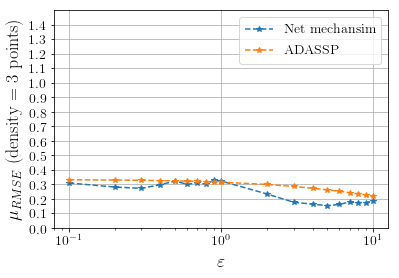

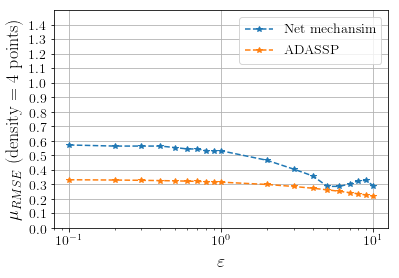

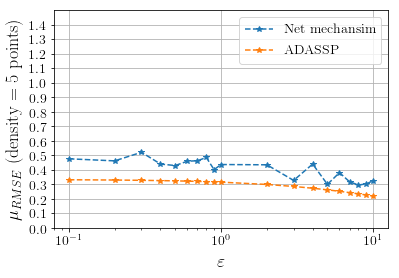

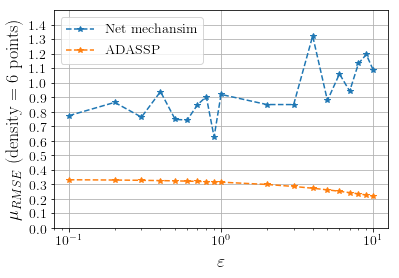

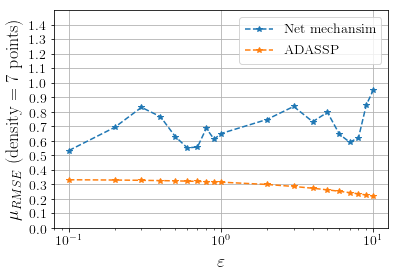

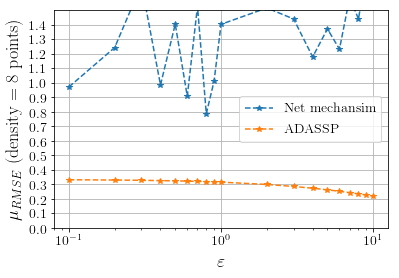

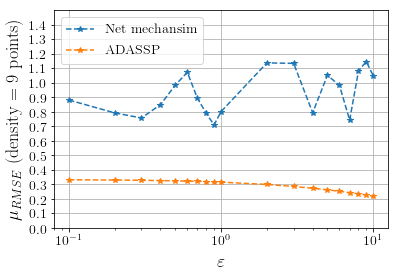

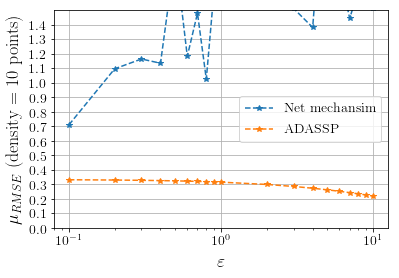

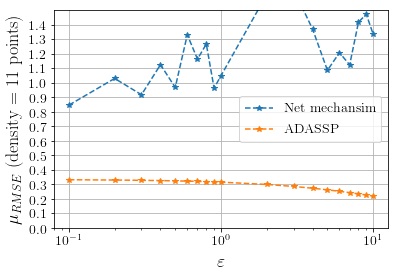

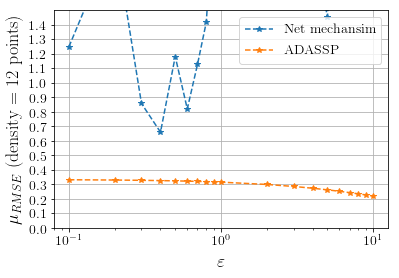

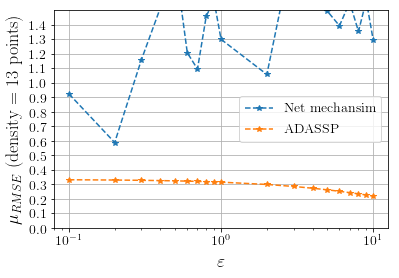

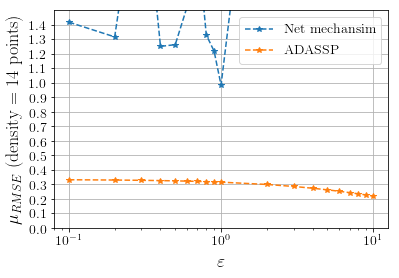

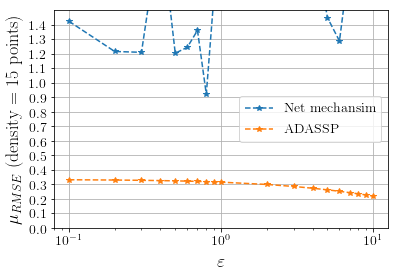

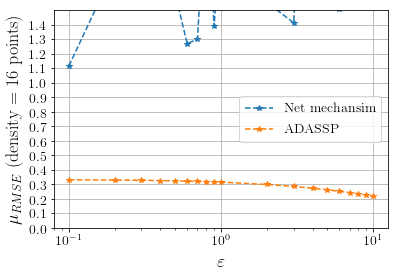

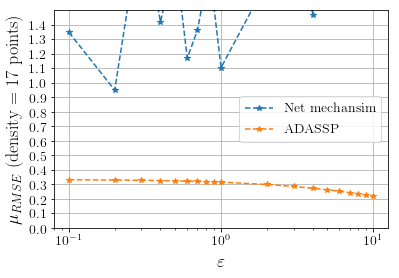

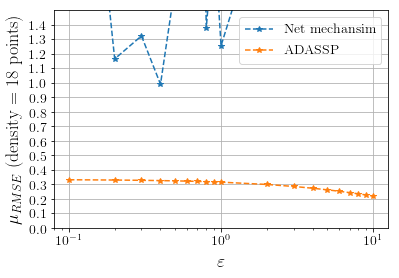

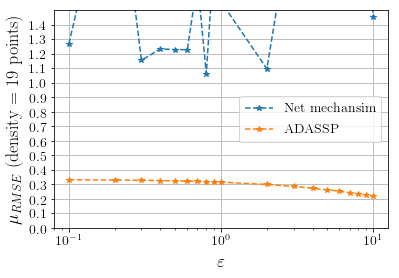

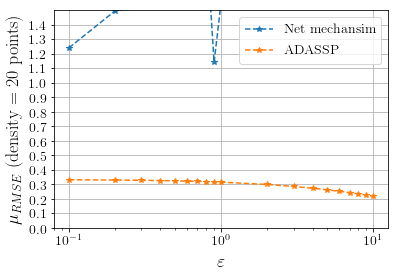

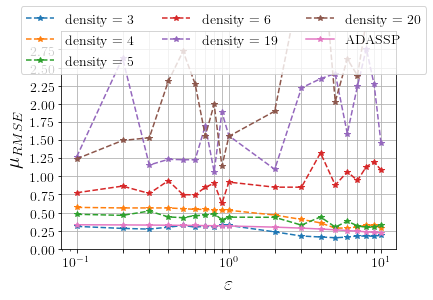

In [19]:
# Calculate variation of RMSE as a function of epsilon
rmse_eps_avg_netmech = {key: [] for key in xcoordinate}
rmse_eps_std_netmech = {key: [] for key in xcoordinate}
rmse_eps_avg_adassp = []
rmse_eps_std_adassp = []

# Extract data
for epsilon in epsilon_vec[0: len(epsilon_vec)]:
    # print ("DEBUG:", mean_predictive_errs_netmech[epsilon])
    # print ("DEBUG:", len(mean_predictive_errs_netmech[epsilon]))
    for index in xcoordinate:
        rmse_eps_avg_netmech[index].append(mean_predictive_errs_netmech[epsilon][index - xcoordinate[0]])
        rmse_eps_std_netmech[index].append(double_std_predictive_errs_netmech[epsilon][index - xcoordinate[0]])

rmse_eps_avg_adassp = [mean_predictive_err_adassp[epsilon] for epsilon in epsilon_vec[0: len(epsilon_vec)]] 
rmse_eps_std_adassp = [double_std_predictive_err_adassp[epsilon] for epsilon in epsilon_vec[0: len(epsilon_vec)]]

def plot_rmse_avg_epsilon(epsilon_vec, rmse_eps_avg_netmech, rmse_eps_avg_adassp, lattice_density, adassp = True):
    plt.semilogx(epsilon_vec, rmse_eps_avg_netmech, '--*', label = 'Net mechansim')
    if adassp:
        plt.plot(epsilon_vec, rmse_eps_avg_adassp, '--*', label = 'ADASSP')
        plt.ylim([0, 1.5]) 
    plt.xlabel(r'$\varepsilon$', fontsize = 18)
    plt.yticks(np.arange(0,1.5, step = 0.1))
   #  plt.xticks(epsilon_vec)
    plt.ylabel('$\mu_{RMSE}$ (density = ' + str(lattice_density) +  ' points)', fontsize = 18)
    plt.legend(fontsize = 14)
    plt.grid(True)
    plt.show()
        
for lattice_density in xcoordinate:
    # print ("DEBUG, rmse_eps_avg_netmech", rmse_eps_avg_netmech[lattice_density])
    plot_rmse_avg_epsilon(epsilon_vec[0: len(epsilon_vec)], rmse_eps_avg_netmech[lattice_density], rmse_eps_avg_adassp, lattice_density, adassp = True)
    
# Plot average RMSE for ADASSP for selected values of the lattice density on the same graph
plt.figure(1)
xcoordinate_range = [3, 4, 5, 6, 19, 20]
#xcoordinate_range = xcoordinate
for lattice_density in xcoordinate_range:
    plt.semilogx(epsilon_vec[0: len(epsilon_vec)], rmse_eps_avg_netmech[lattice_density], '--*', label = 'density = ' + str(lattice_density))
plt.plot(epsilon_vec[0: len(epsilon_vec)], rmse_eps_avg_adassp,'-*', label = 'ADASSP')
plt.xlabel(r'$\varepsilon$', fontsize = 20)
plt.ylabel('$\mu_{RMSE}$', fontsize = 20)
plt.xticks(epsilon_vec[0: len(epsilon_vec)])
plt.yticks(np.arange(0,3, step = 0.25))
plt.ylim([0, 3]) 
plt.grid(True)
plt.legend(fontsize = 14, bbox_to_anchor=(0.5, 0.85), bbox_transform = plt.gcf().transFigure, loc = 'center', ncol = 3)
plt.show()

#### Variation of the RMSE standard deviation with $\varepsilon$ for different lattice densities

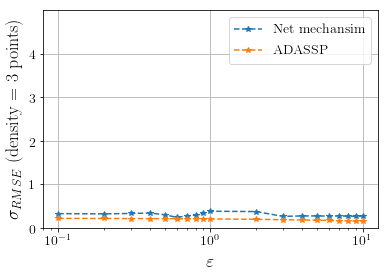

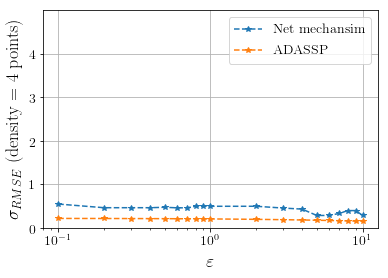

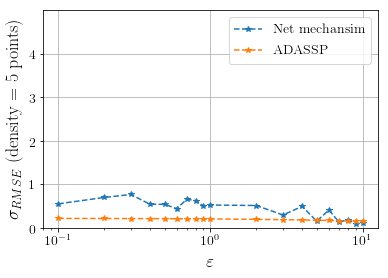

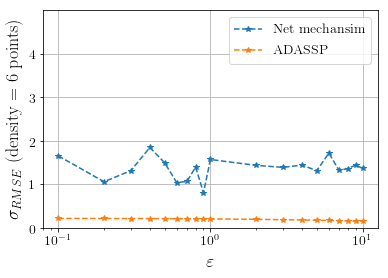

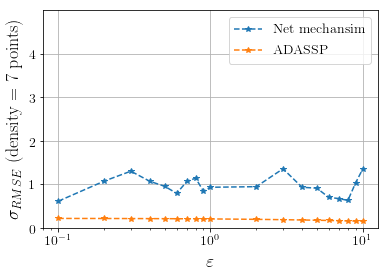

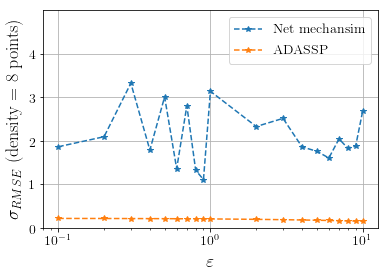

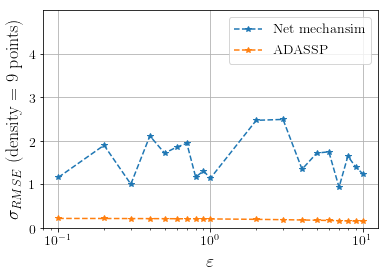

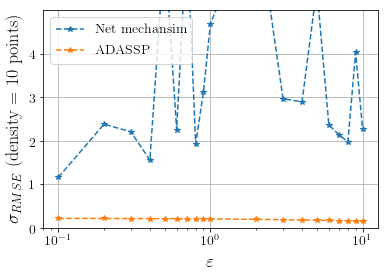

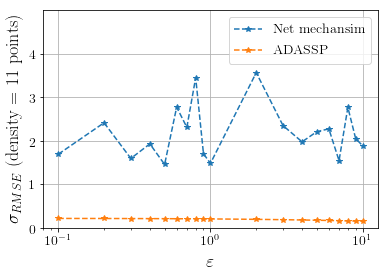

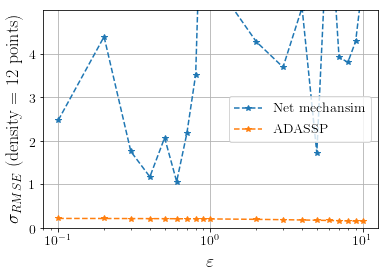

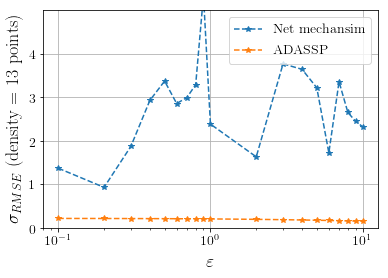

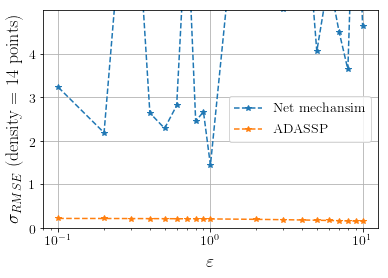

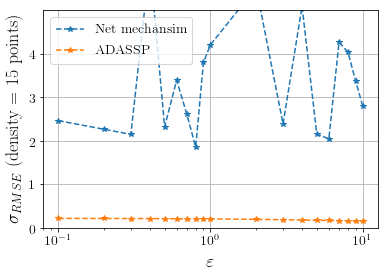

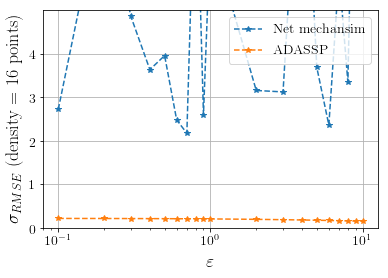

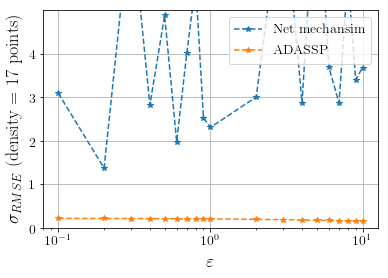

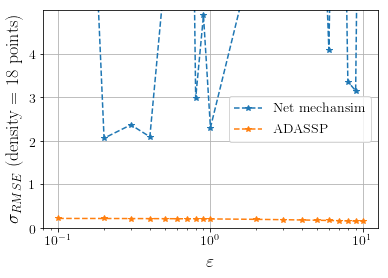

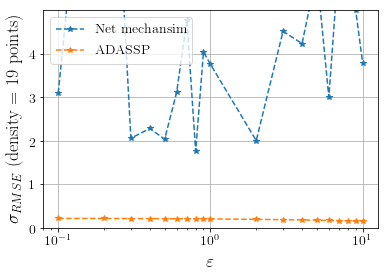

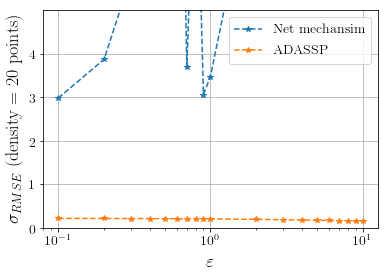

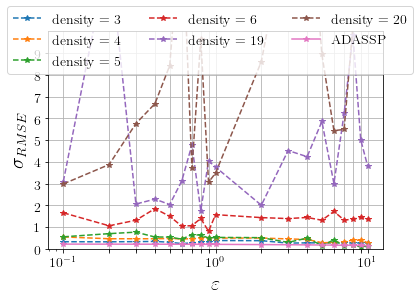

In [21]:
def plot_rmse_std_epsilon(epsilon_vec, rmse_eps_std_netmech, rmse_eps_std_adassp, lattice_density, adassp = True):
    plt.semilogx(epsilon_vec, rmse_eps_std_netmech, '--*', label = 'Net mechansim')
    if adassp:
        plt.plot(epsilon_vec, rmse_eps_std_adassp, '--*', label = 'ADASSP')
        # plt.ylim([0, 1]) 
    plt.xlabel(r'$\varepsilon$', fontsize = 18)
    plt.yticks(np.arange(0,5, step = 1))
    plt.ylim([0, 5])
   #  plt.xticks(epsilon_vec)
    plt.ylabel(r'$\sigma_{RMSE}$ (density = ' + str(lattice_density) +  ' points)', fontsize = 18)
    plt.legend(fontsize = 14)
    plt.grid(True)
    plt.show()
        
for lattice_density in xcoordinate:
    # print ("DEBUG, rmse_eps_std_netmech", rmse_eps_std_netmech[lattice_density])
    plot_rmse_std_epsilon(epsilon_vec[0: len(epsilon_vec)], rmse_eps_std_netmech[lattice_density], rmse_eps_std_adassp, lattice_density, adassp = True)

# Plot average RMSE for ADASSP for selected values of the lattice density on the same graph
plt.figure(1)
xcoordinate_range = [3, 4, 5, 6, 19, 20]
for lattice_density in xcoordinate_range:
    plt.semilogx(epsilon_vec[0: len(epsilon_vec)], rmse_eps_std_netmech[lattice_density], '--*', label = 'density = ' + str(lattice_density))
plt.plot(epsilon_vec[0: len(epsilon_vec)], rmse_eps_std_adassp,'-*', label = 'ADASSP')
plt.xlabel(r'$\varepsilon$', fontsize = 20)
plt.ylabel(r'$\sigma_{RMSE}$', fontsize = 20)
plt.xticks(epsilon_vec[0: len(epsilon_vec)])
plt.yticks(np.arange(0, 10, step = 1))
plt.ylim([0, 10]) 
plt.grid(True)
plt.legend(fontsize = 14, bbox_to_anchor=(0.5, 0.85), bbox_transform = plt.gcf().transFigure, loc = 'center', ncol = 3)
plt.show()

#### Correlations difference norm 

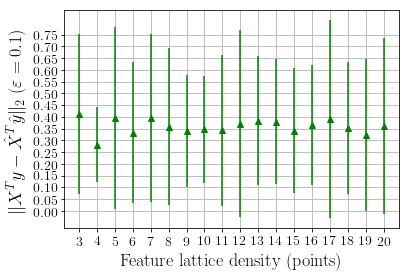

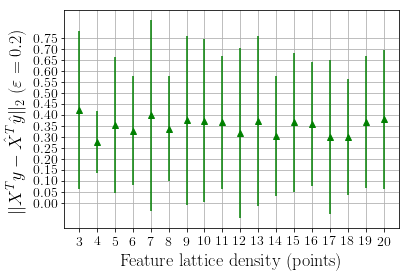

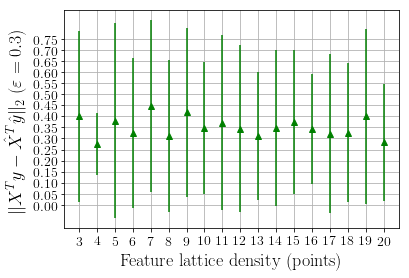

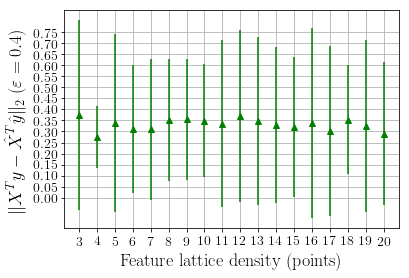

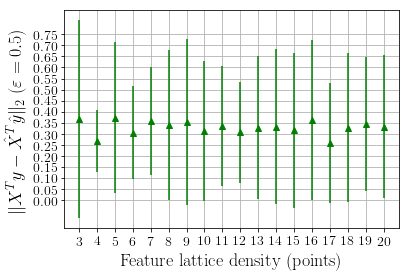

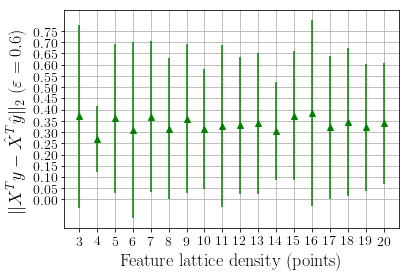

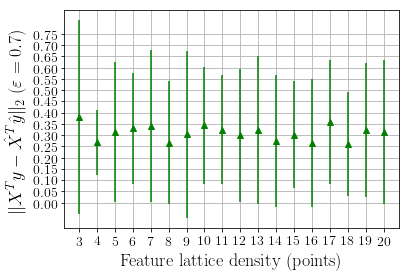

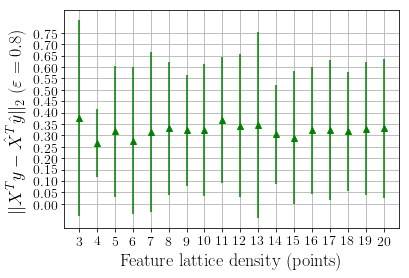

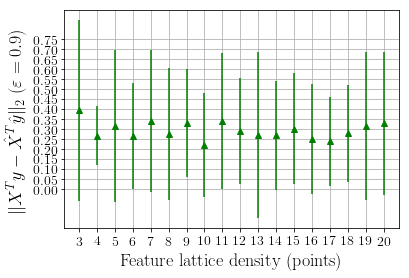

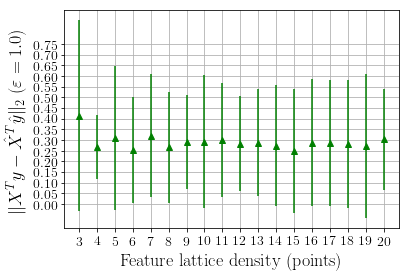

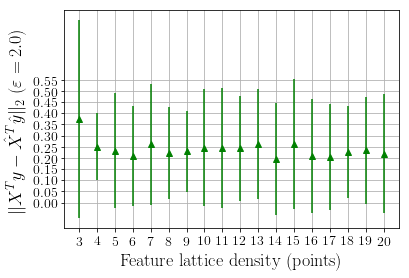

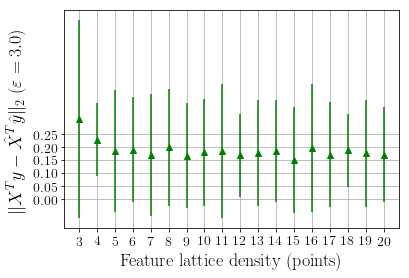

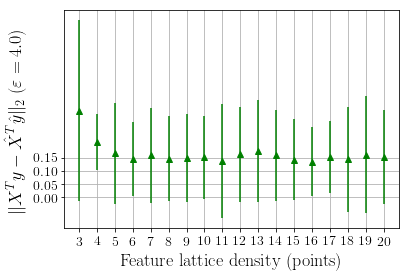

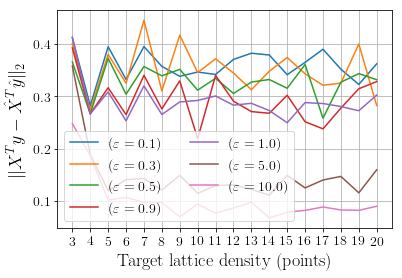

In [22]:
def plot_corr_diff_norm(xcoordinate, avg_2_norms, double_std_2_norms, yticks_up, epsilon):
    plt.errorbar(xcoordinate, avg_2_norms, yerr = double_std_2_norms, fmt = 'g^')
    plt.xticks(xcoordinate)
    plt.yticks(np.arange(0, yticks_up, step = 0.05))
    plt.xlabel('Feature lattice density (points)', fontsize = 18)
    plt.ylabel(r'$\|X^Ty - \hat{X}^T\hat{y}\|_2$ ($\varepsilon =' + str(epsilon) + '$)', fontsize = 18)
    plt.grid(True)
    plt.show()
yticks_up_vec = [0.8, 0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8, 0.6, 0.3, 0.2]
for epsilon, yticks_up in zip(epsilon_vec, yticks_up_vec):
    plot_corr_diff_norm(xcoordinate, avg_2_norms[epsilon], double_std_2_norms[epsilon], yticks_up, epsilon)

eps_range = [0.1,0.3,0.5,0.9,1.0,5.0,10.0]    
for epsilon in eps_range:
    plt.plot(xcoordinate, avg_2_norms[epsilon], label = r'($\varepsilon =' + str(epsilon) + '$)')
plt.xticks(xcoordinate)
plt.xlabel('Target lattice density (points)', fontsize = 18)
plt.ylabel(r'$\|X^Ty - \hat{X}^T\hat{y}\|_2$', fontsize = 18)
plt.legend(fontsize = 14, ncol = 2)
plt.grid(True)
plt.show()

#### Frobenius norms

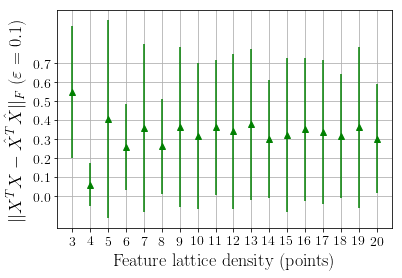

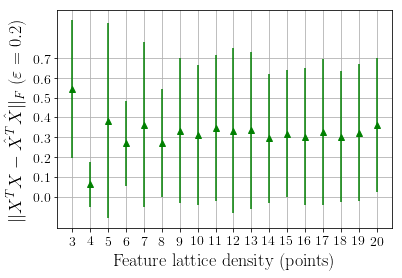

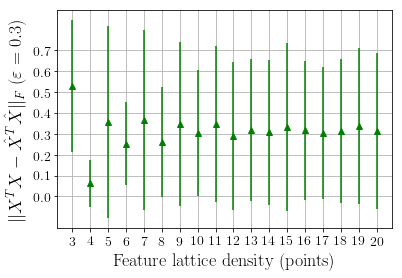

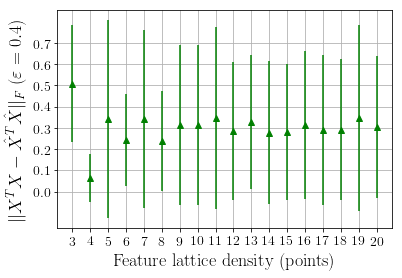

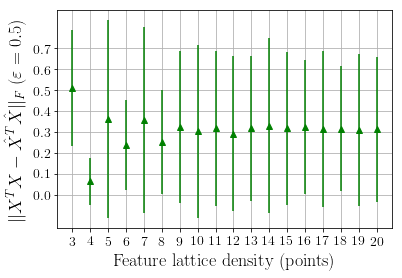

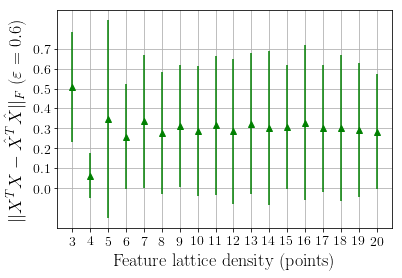

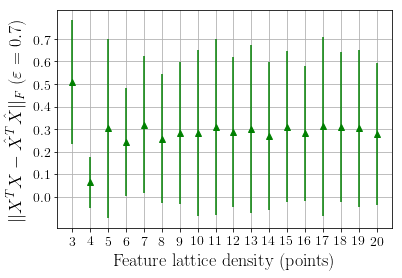

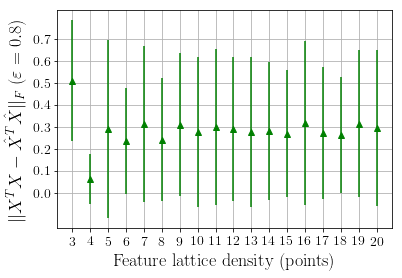

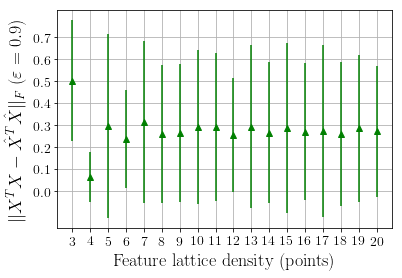

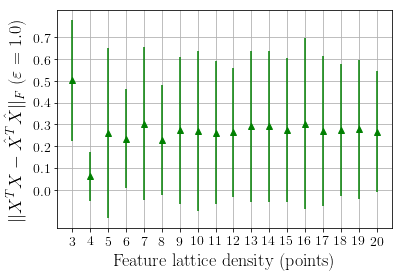

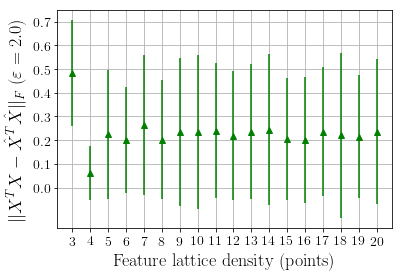

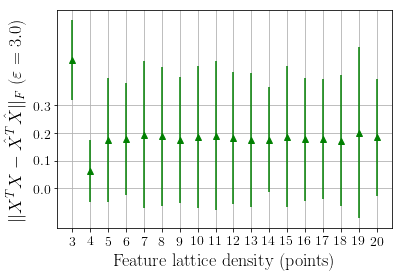

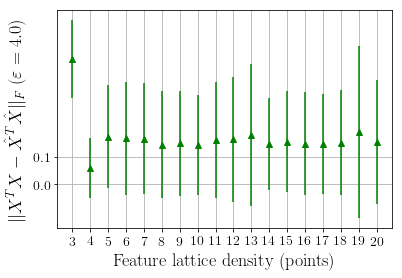

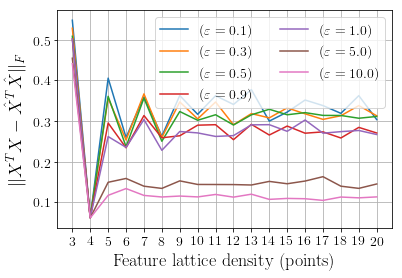

In [23]:
def plot_f_norms_errb(xcoordinate, avg_f_norms, double_std_f_norms, yticks_up, epsilon):
    plt.errorbar(xcoordinate, avg_f_norms, yerr = double_std_f_norms, fmt = 'g^')
    plt.xticks(xcoordinate)
    plt.yticks(np.arange(0, yticks_up, step = 0.1))
    plt.xlabel('Feature lattice density (points)', fontsize = 18)
    plt.ylabel(r'$\|X^TX - \hat{X}^T \hat{X} \|_F$ ($\varepsilon = ' + str(epsilon) + '$)', fontsize = 18)
    plt.grid(True)
    plt.show()

yticks_up_vec = [0.8, 0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8, 0.4, 0.2]

for epsilon, yticks_up in zip(epsilon_vec, yticks_up_vec):
    plot_f_norms_errb(xcoordinate, avg_f_norms[epsilon], double_std_f_norms[epsilon], yticks_up, epsilon)

eps_range = [0.1,0.3,0.5,0.9,1.0,5.0,10.0]    
for epsilon in eps_range:
    plt.plot(xcoordinate, avg_f_norms[epsilon], label = r'($\varepsilon = ' + str(epsilon) + '$)')
plt.xticks(xcoordinate)
plt.xlabel('Feature lattice density (points)', fontsize = 18)
plt.ylabel(r'$\|X^TX - \hat{X}^T \hat{X} \|_F$', fontsize = 18)
plt.legend(fontsize = 14, ncol = 2)
plt.grid(True)
plt.show()

#for epsilon in epsilon_vec:
    # print(double_std_f_norms[epsilon])
#    plt.errorbar(xcoordinate, avg_f_norms[epsilon], yerr = double_std_f_norms[epsilon], label = r'($\varepsilon = ' + str(epsilon) + '$)')
#plt.xticks(xcoordinate)
#plt.xlabel('Lattice density (points)', fontsize = 16)
#plt.ylabel(r'$\|X^TX - \hat{X}^T \hat{X} \|_F$', fontsize = 16)
#plt.legend(fontsize = 13)
#plt.grid(True)
#plt.show()

#### Optimal utility

In [ ]:
# Independent of epsilon, all the experiments return the same utility
epsilon = 0.1
plt.plot(xcoordinate, max_utilities[epsilon], 'r*', label = 'Optimal utility')
plt.xticks(xcoordinate)
plt.yticks(np.arange(-0.2, 0.0, step = 0.025))
plt.xlabel('Feature lattice density (points)', fontsize = 18)
plt.ylabel('max $u$', fontsize = 18)
plt.ylim([-0.2,0])
plt.grid(True)
# plt.legend(fontsize = 13)
plt.show()
print(max_utilities)

In [ ]:
# Sanity check recalculate the maximum utility from the recovered data 

#### Minimum sample error for ADASSP vs netmechanism

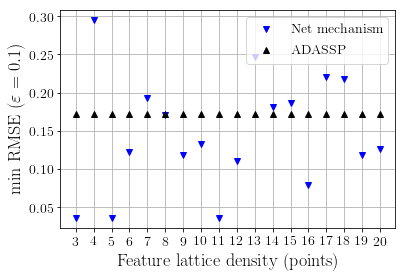

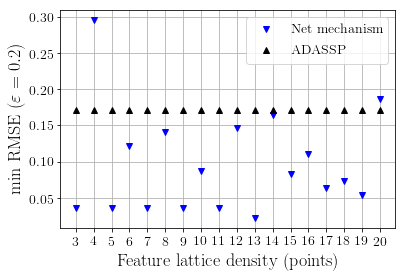

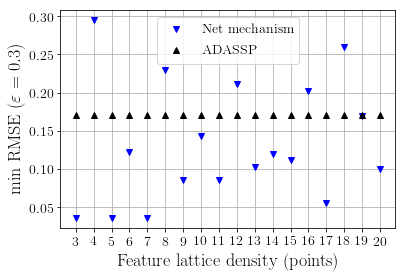

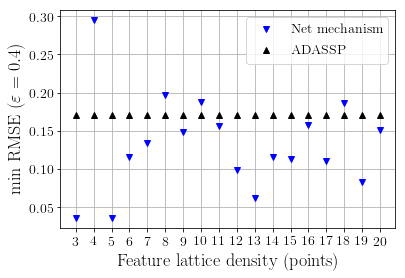

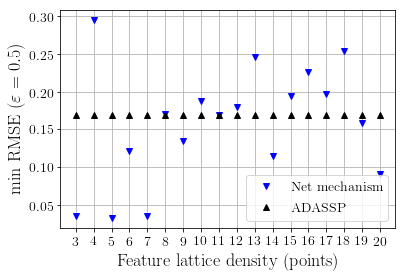

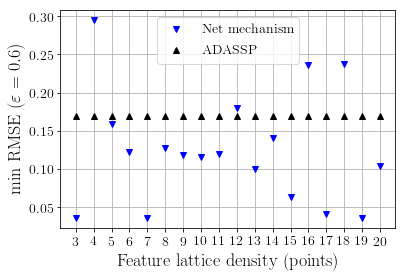

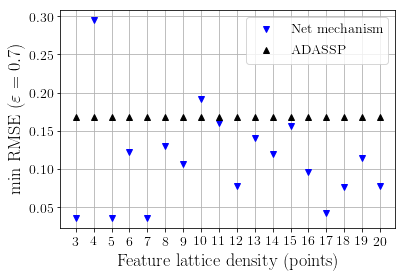

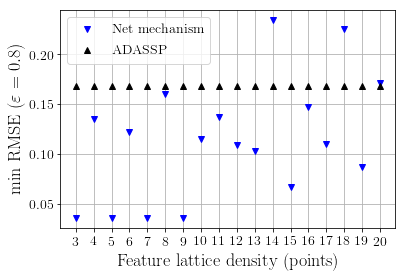

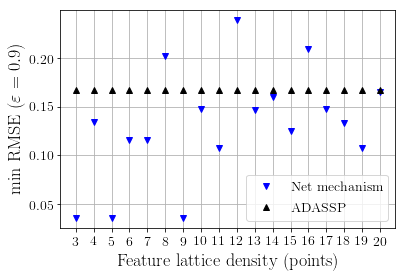

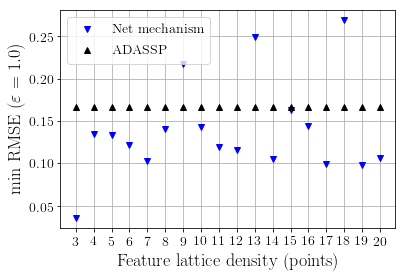

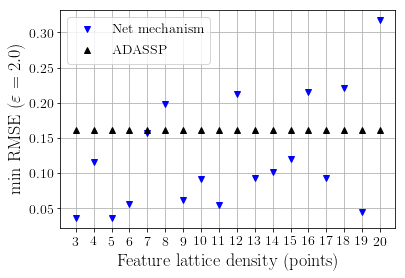

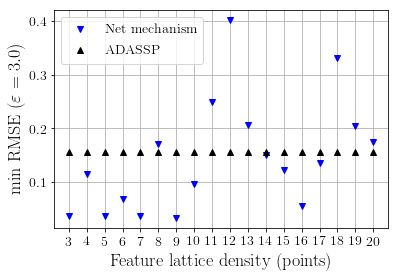

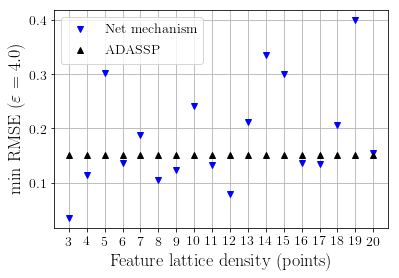

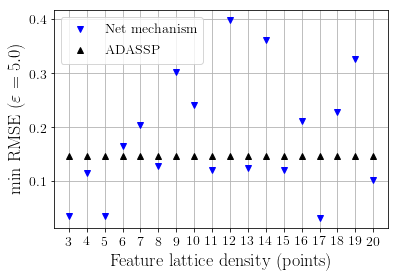

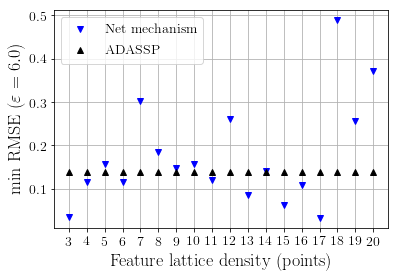

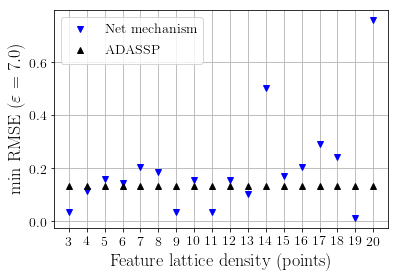

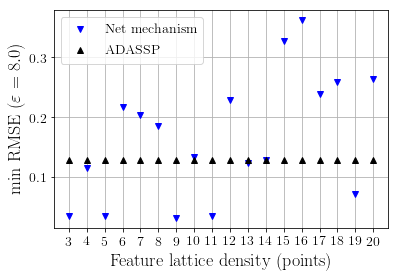

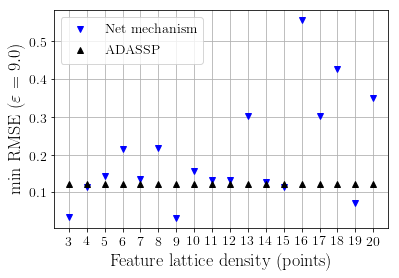

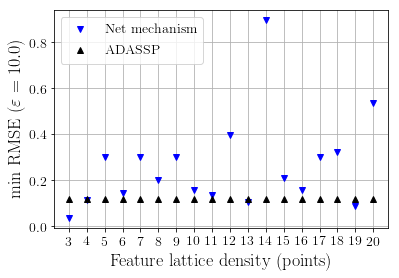

In [24]:
def plot_min_rmses(xcoordinate, min_predictive_errs_netmech, min_predictive_err_adassp, epsilon):
    plt.plot(xcoordinate, min_predictive_errs_netmech, 'bv', label = 'Net mechanism',  )
    plt.plot(xcoordinate, [min_predictive_err_adassp]*len(xcoordinate), 'k^', label = 'ADASSP')
    plt.xlabel('Feature lattice density (points)', fontsize = 18)
    plt.ylabel(r'$\min$ RMSE ($\varepsilon =' + str(epsilon) + '$)', fontsize = 18)
    plt.xticks(xcoordinate)
    plt.legend(fontsize = 14)
    plt.grid(True)
    plt.show()
    
for epsilon in epsilon_vec:
    plot_min_rmses(xcoordinate, min_predictive_errs_netmech[epsilon], min_predictive_err_adassp[epsilon], epsilon)

#### Does better utility imply better "norm values" and better RMSE?

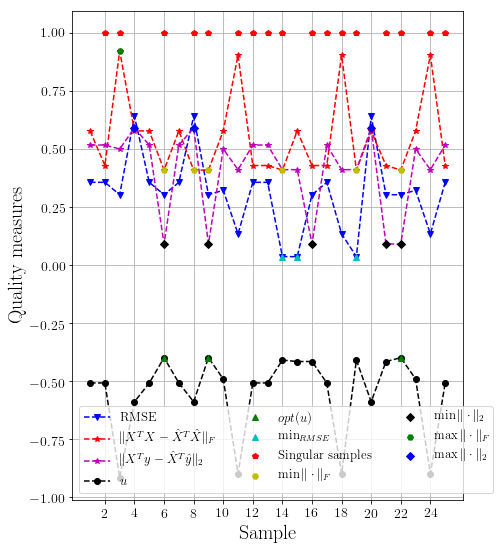

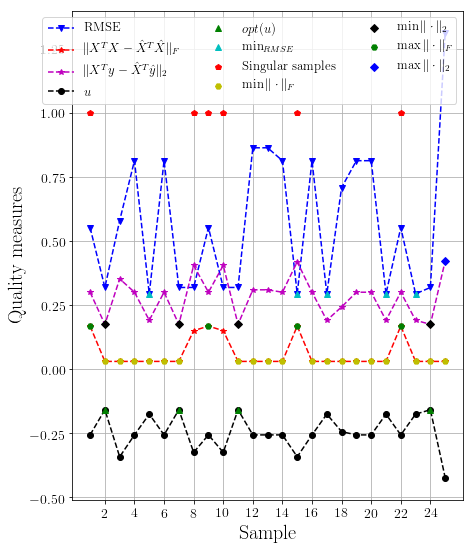

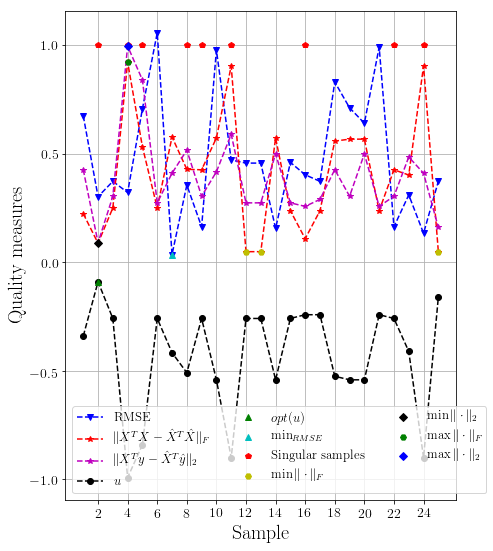

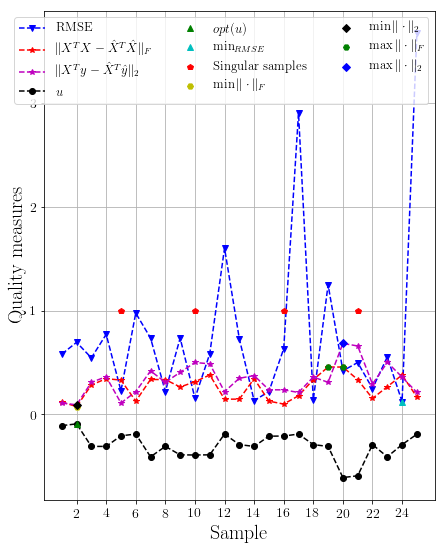

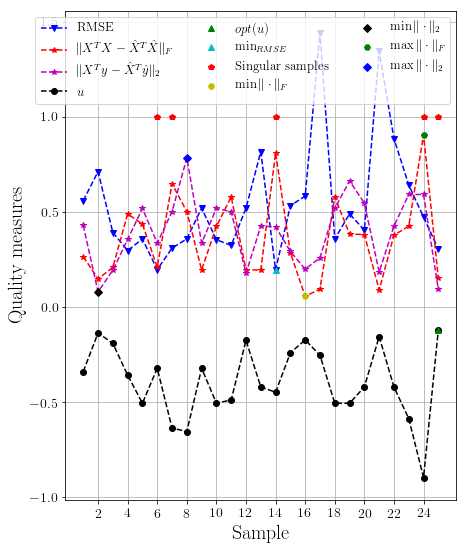

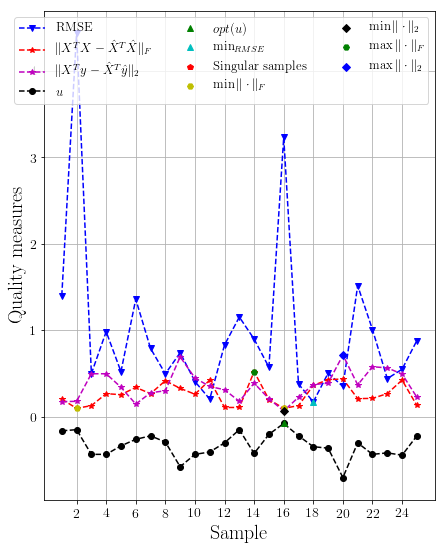

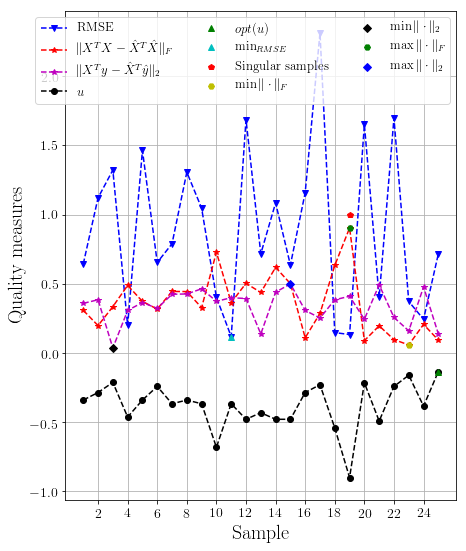

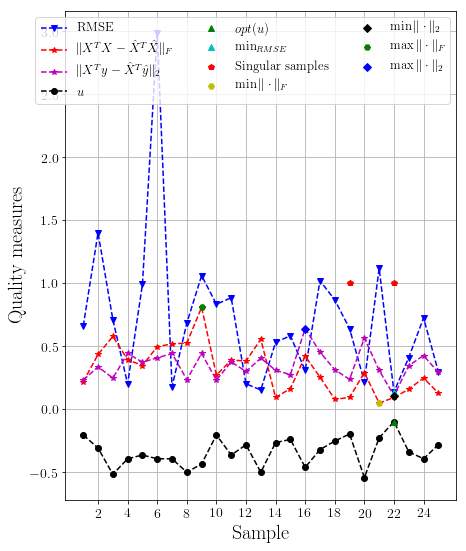

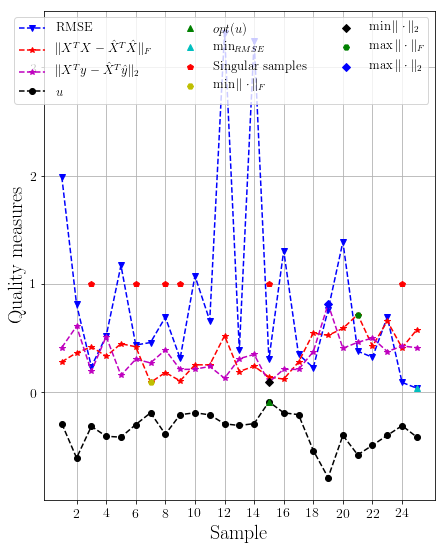

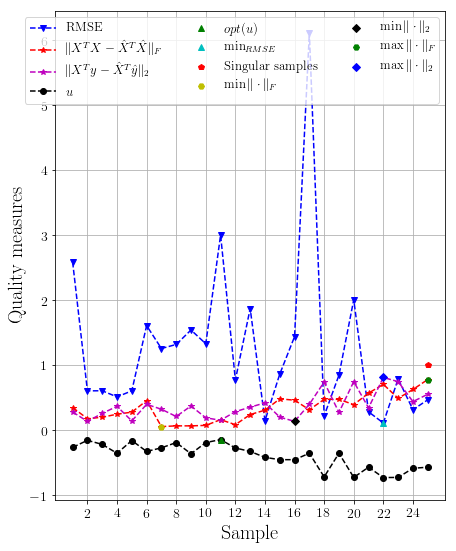

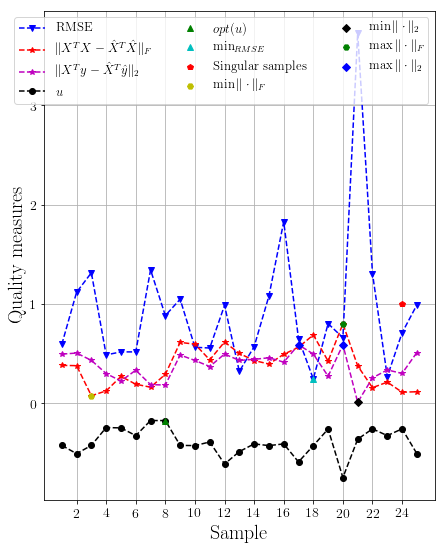

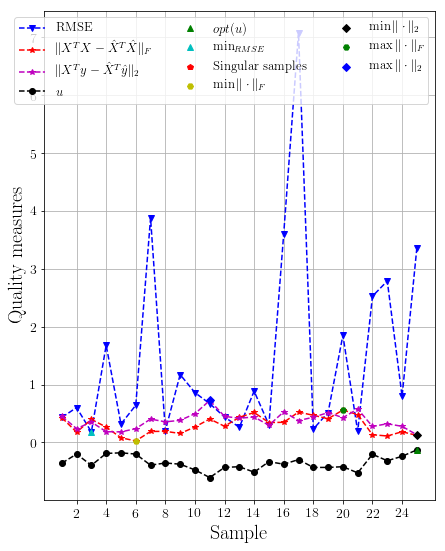

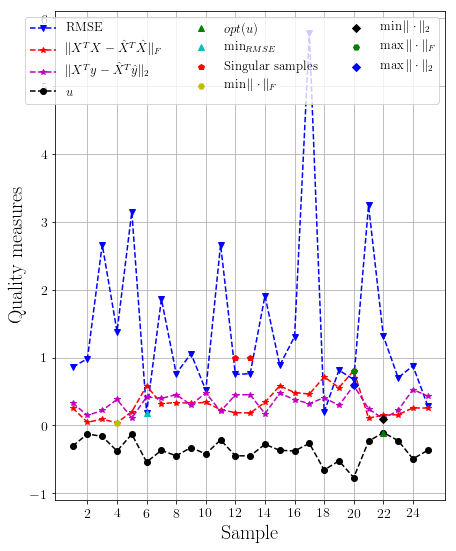

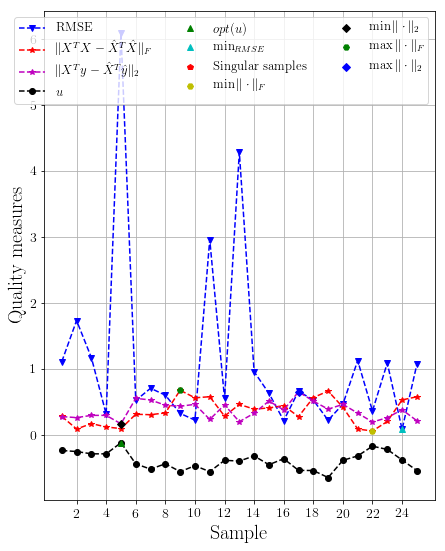

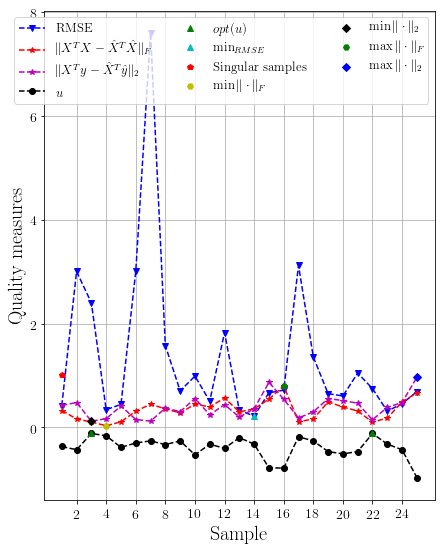

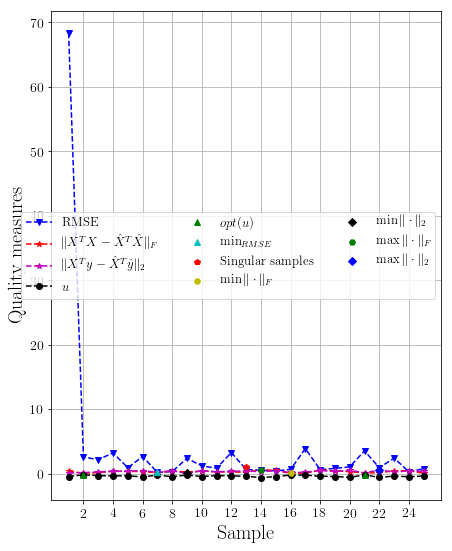

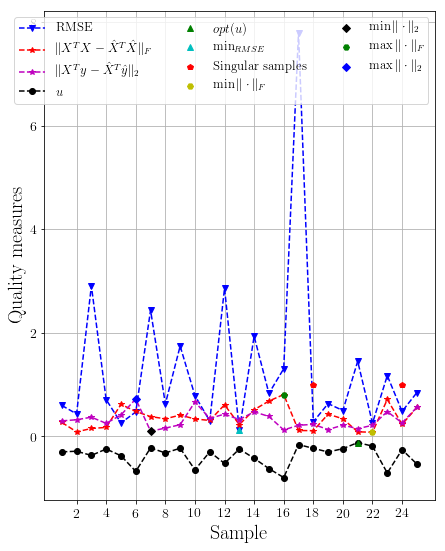

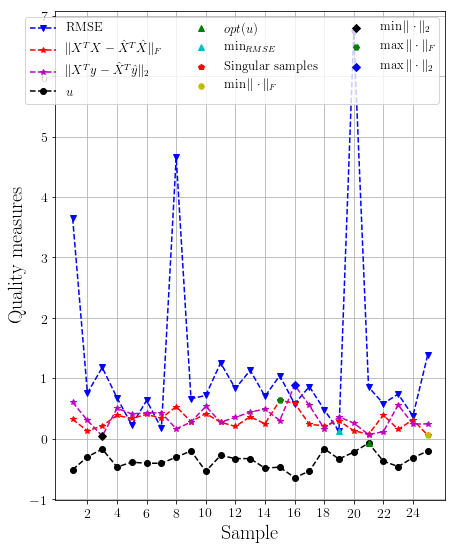

In [25]:
# %matplotlib tk

def plot_statistics(num_samples, predictive_errs_netmech, delta_cov_norms_f, delta_corr_norms_2, sample_utilities, epsilon, \
                   lattice_density, singular_indices, singular_indices_val):
    
    sample_utilities = np.array(sample_utilities)
    predictive_errs_netmech = np.squeeze(predictive_errs_netmech)
    delta_corr_norms_2 = np.squeeze(delta_corr_norms_2)
    xcoordinate = range(1, num_samples + 1)
    
    # Calculate extrema of:
    sampled_utilities_max_idx = np.argwhere( np.isclose(sample_utilities - np.max(sample_utilities), 0.0, rtol = 1e-9))
    predictive_errs_netmech_min_idx = np.argwhere(np.isclose(predictive_errs_netmech - np.min(predictive_errs_netmech), 0.0, rtol = 1e-9))
    delta_cov_norms_f_min_idx = np.argwhere(np.isclose(delta_cov_norms_f - np.min(delta_cov_norms_f), 0.0, rtol = 1e-9))
    delta_corr_norms_2_min_idx = np.argwhere(np.isclose(delta_corr_norms_2 - np.min(delta_corr_norms_2), 0.0, rtol = 1e-9))
    delta_cov_norms_f_max_idx = np.argwhere(np.isclose(delta_cov_norms_f - np.max(delta_cov_norms_f), 0.0, rtol = 1e-9))
    delta_corr_norms_2_max_idx = np.argwhere(np.isclose(delta_corr_norms_2 - np.max(delta_corr_norms_2), 0.0, rtol = 1e-9))

    plt.figure(figsize=(7,9))
    plt.plot(xcoordinate, predictive_errs_netmech, '--bv', label = 'RMSE' )
    plt.plot(xcoordinate, delta_cov_norms_f, '--*r', label = r'$\|X^TX - \hat{X}^T \hat{X} \|_F$' )
    plt.plot(xcoordinate, delta_corr_norms_2, '--*m', label = r'$\|X^Ty - \hat{X}^T\hat{y}\|_2$' )
    plt.plot(xcoordinate, sample_utilities, '--ok', label = '$u$')
   # plt.plot(np.argmax(sample_utilities) + 1, sample_utilities[np.argmax(sample_utilities)],'^g', label = r'$opt(u)$')
    plt.plot(1 + sampled_utilities_max_idx, sample_utilities[sampled_utilities_max_idx], '^g', label = r'$opt(u)$')
   # plt.plot(np.argmin(predictive_errs_netmech) + 1, predictive_errs_netmech[np.argmin(predictive_errs_netmech)], '^c', label = r'$\min_{RMSE}$')
    plt.plot(1 + predictive_errs_netmech_min_idx ,predictive_errs_netmech[predictive_errs_netmech_min_idx], '^c', label = r'$\min_{RMSE}$')
    plt.plot(1 + singular_indices[0], [singular_indices_val]*singular_indices[0].shape[0], 'rp' ,label =  'Singular samples')
    plt.plot(1 + delta_cov_norms_f_min_idx, delta_cov_norms_f[delta_cov_norms_f_min_idx], 'Hy', label = r'$\min \| \cdot \|_{F}$')
    plt.plot(1 + delta_corr_norms_2_min_idx, delta_corr_norms_2[delta_corr_norms_2_min_idx], 'Dk', label = r'$\min \| \cdot \|_{2}$')
    plt.plot(1 + delta_cov_norms_f_max_idx, delta_cov_norms_f[delta_cov_norms_f_max_idx], 'Hg', label = r'$\max \| \cdot \|_{F}$')
    plt.plot(1 + delta_corr_norms_2_max_idx, delta_corr_norms_2[delta_corr_norms_2_max_idx], 'Db', label = r'$\max \| \cdot \|_{2}$')
    xticks = [x for x in xcoordinate if x%2 == 0]
    plt.xticks(xticks)
    # plt.yticks(np.arange(0, 6, step = 1))
    plt.xlabel('Sample', fontsize = 20)
    plt.ylabel('Quality measures', fontsize = 20)
    plt.legend(fontsize = 13, ncol = 3)
    # plt.title(r'$\varepsilon = ' +  str(epsilon) + '$, density = ' + str(lattice_density), fontsize = 20)
    plt.grid(True)
    plt.show()

singular_indices_val = 1
epsilon_range = [0.1]
xcoordinate_range = xcoordinate
for epsilon in epsilon_range:
    for lattice_density in xcoordinate_range:
        plot_statistics(num_samples, predictive_errs_netmech[epsilon][lattice_density - num_points_min], delta_cov_norms_f[epsilon][lattice_density - num_points_min],\
                        delta_corr_norms_2[epsilon][lattice_density - num_points_min], sample_utilities[epsilon][lattice_density - num_points_min], \
                        epsilon, lattice_density, singular_indices[epsilon][lattice_density - num_points_min], singular_indices_val)

### Save data for cross-experiment comparisons

In [26]:
data = {}
data['delta_opt_avg'] = delta_opt_avg
data['delta_opt_best'] = delta_opt_best
data['max_utilities'] = max_utilities
data['rmse_eps_avg_netmech'] = rmse_eps_avg_netmech
data['rmse_eps_avg_adassp'] = rmse_eps_avg_adassp

In [27]:
filename = 'exp_feature_data'
with open (directory + filename, 'wb') as container:
    pickle.dump(data, container)

# Sanity checks

### Check that the data is consistent (NB: needs slight modification of the results unpacking function)

In [ ]:
# Check that the same test and private data has been used for all the experiments
for prev_eps, next_eps in zip(epsilon_vec, epsilon_vec[1:]):
    for set_1, set_2 in zip(private_data[prev_eps], private_data[next_eps]):
        assert np.all(set_1.test_data == set_2.test_data)
        assert np.all(set_1.test_targets == set_2.test_targets)
        assert np.all(set_1.test_features == set_2.test_features)
        assert np.all(set_1.features == set_2.features)
        assert np.all(set_1.data == set_2.data)
        assert np.all(set_1.targets == set_2.targets)

### Plot the data...

In [ ]:
data = private_data[0.1]
data.plot_data(angle_1 = 45)
plt.show()

### Replot the average utility graphs

NB: This is obtained by using 1 single very large batch for utility calculation. The data is saved to the disk and then reloaded at sampling time. Results are identical.

In [ ]:
def plot_avg_utility_graphs(yticks_low, xcoordinate, avg_samples_utility, double_std_utility, max_utilities, max_sampled_utilities,\
                            epsilon):
    plt.errorbar(xcoordinate, avg_samples_utility, yerr = double_std_utility, fmt = 'g^', label = 'Mean samples utility')
    plt.plot(xcoordinate, max_utilities, 'r*', label = 'Optimal utility')
    plt.plot(xcoordinate, max_sampled_utilities, 'ko', label = 'Max samples utility')
    plt.xticks(xcoordinate)
    # plt.yticks(np.arange(yticks_low, 0.02, step = 0.05))
    plt.xlabel('Lattice denisity (points)', fontsize = 16)
    plt.ylabel(r'$\mu_u$ ($\varepsilon =' + str(epsilon) + '$)', fontsize = 16)
    plt.legend(fontsize = 13)
    plt.grid(True)
    plt.show()

for epsilon in epsilon_vec:
    plot_avg_utility_graphs(yticks_low, xcoordinate, avg_samples_utility[epsilon], double_std_utility[epsilon],\
                            max_utilities[epsilon], max_sampled_utilities[epsilon], epsilon)
    

### Recalculate max utility from raw data

In [ ]:
# Retrieve scaling constants and check they're correct (NB: scaled utilities are saved to disk)
scaling_constants = []
for epsilon in epsilon_vec:
    scaling_constants.append(results[epsilon][0]['scaling_const'])
    for i in range(len(num_points_features_vec)):
        pass
        # print('DEBUG: scaling constant for epsilon {} and lattice density {} is {}'.format(str(epsilon), str(i + 3), str(results[epsilon][i]['scaling_const']))
print ("DEBUG: scaling constants", scaling_constants)
print (len(scaling_constants))

In [ ]:
# Calculate the optimal utilities from raw data saved on disk
filenames = {key: [] for key in epsilon_vec}
for epsilon in epsilon_vec:
    for i in range(len(num_points_features_vec)):
        filenames[epsilon].append(results[epsilon][i]['filenames'][0][0])

max_utils_debug = {key: [] for key in epsilon_vec}

for scaling_const, epsilon in zip(scaling_constants, epsilon_vec):
    for filename in filenames[epsilon]:
        print(filename)
        with open (filename, 'rb') as container:
            scaled_utilities = pickle.load(container)
        max_utils_debug[epsilon].append(np.max(1/scaling_const*scaled_utilities['scaled_utilities']))

In [ ]:
# Check everything is consistent (should remain constant across epsilon range)
for key in max_utils_debug.keys():
    max_utils_debug[key] = np.array(max_utils_debug[key])
for prev_eps, next_eps in zip(epsilon_vec, epsilon_vec[1:]):
    print ("DEBUG: prev eps", prev_eps)
    print ("DEBUG: next_eps", next_eps)
    print ("DEBUG: max_utils_debug[prev_eps]", max_utils_debug[prev_eps])
    print ("DEBUG: max_utils_debug[next_eps]", max_utils_debug[next_eps])
    print (max_utils_debug[prev_eps] - max_utils_debug[next_eps])
    assert np.allclose(max_utils_debug[prev_eps] - max_utils_debug[next_eps], 0.0 ,rtol = 1e-5)

In [ ]:
# Independent of epsilon, all the experiments return the same utility.
# Plot the recalculated utilities (NB: identical with what was obtained before)
epsilon = 0.1
plt.plot(xcoordinate, max_utils_debug[epsilon], 'r*', label = 'Optimal utility')
plt.xticks(xcoordinate)
plt.yticks(np.arange(-0.07, 0.0, step = 0.005))
plt.xlabel('Lattice density (points)', fontsize = 16)
plt.ylabel('max $u$', fontsize = 16)
plt.ylim([-0.3,0])
plt.grid(True)
# plt.legend(fontsize = 13)
plt.show()